In [96]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

[ 0  1 10 11 12 13 14]
[0 1 2 3 4 5 6]
(83, 86)


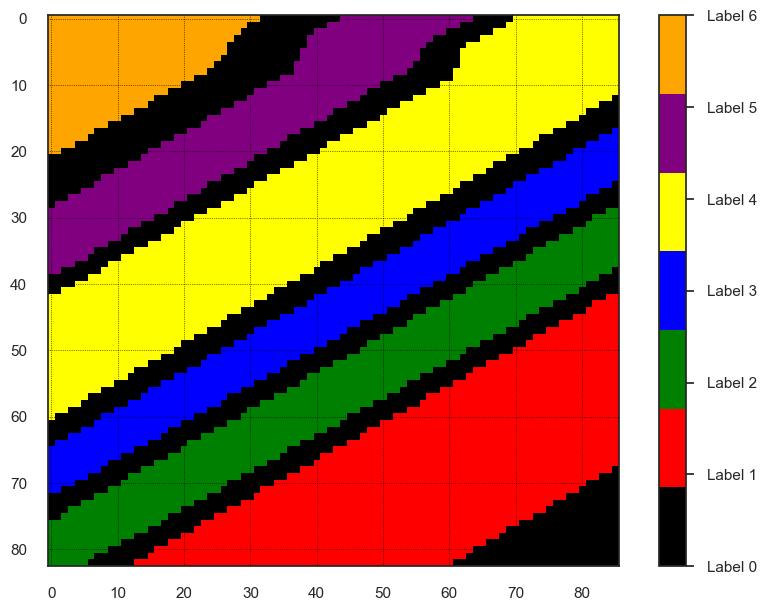

[[6 6 6 ... 4 4 4]
 [6 6 6 ... 4 4 4]
 [6 6 6 ... 4 4 4]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]


In [97]:
import scipy.io

# Load .mat file
SalinasA= np.array(scipy.io.loadmat('SalinasA.mat')['salinasA'])
SalinasA_corrected= np.array(scipy.io.loadmat('SalinasA_corrected.mat')['salinasA_corrected'])
SalinasA_gt= np.array(scipy.io.loadmat('SalinasA_gt.mat')['salinasA_gt'])

i=0
label_data = [0,6,1,5,4,3,2]
print(np.unique(SalinasA_gt))
for ele in np.unique(SalinasA_gt):
    #print(ele)
    mask = SalinasA_gt==ele
    SalinasA_gt[mask] = label_data[i]
    #print(SalinasA_gt)
    i=i+1
    #print(i+1)
print(np.unique(SalinasA_gt))

print(SalinasA_gt.shape)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Define a colormap with colors for each label
colors = ['black', 'red', 'green', 'blue', 'yellow', 'purple', 'orange']
cmap = ListedColormap(colors)

plt.imshow(SalinasA_gt, cmap=cmap, vmin=0, vmax=len(colors)-1)

# Add colorbar to show label-color mapping
cbar = plt.colorbar(ticks=np.arange(len(colors)))
cbar.set_ticklabels([f'Label {i}' for i in range(len(colors))])
# Add a label at a specific coordinate (e.g., x=5, y=5)
#label_text = "A"
#plt.text(20, 10, label_text, color='red', fontsize=4, ha='center', va='center')
# Set ticks to align with individual pixels
#plt.xticks(np.arange(0.0, 87.0, 1), [])
#plt.yticks(np.arange(0.0, 84.0, 1), [])
plt.grid(True, which='both', color='black', linewidth=0.5, linestyle=':')
plt.show()
print(SalinasA_gt)

In [98]:
SalinasA_gt.shape, SalinasA_corrected.shape

((83, 86), (83, 86, 204))

In [99]:
column = 20
y_obs = torch.tensor(SalinasA_gt[:,column], dtype=torch.float64)
mask = y_obs!=0
print(mask)
y_obs_label = y_obs[mask]
print(len(y_obs_label))
print(SalinasA_corrected.shape)
y_obs_hsi = torch.tensor(SalinasA_corrected[:,column,:], dtype=torch.float64)[mask]
y_obs_hsi.shape

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False,  True,  True,
         True,  True,  True])
59
(83, 86, 204)


torch.Size([59, 204])

In [100]:
y_obs_hsi

tensor([[376., 481., 731.,  ...,   2.,   0.,   0.],
        [363., 493., 684.,  ...,   6.,   1.,   0.],
        [363., 493., 684.,  ...,   6.,   1.,   0.],
        ...,
        [376., 392., 599.,  ...,  30.,  12.,  19.],
        [294., 307., 597.,  ...,  33.,  13.,  21.],
        [294., 307., 597.,  ...,  33.,  13.,  21.]], dtype=torch.float64)

In [101]:
from scipy.stats import zscore

In [102]:
normalised_hsi = zscore(y_obs_hsi, axis=0)
normalised_hsi

tensor([[-0.0917, -0.1022,  0.6458,  ..., -2.0414, -2.0789, -2.1446],
        [-0.3896,  0.0792, -0.0924,  ..., -1.8319, -1.9459, -2.1446],
        [-0.3896,  0.0792, -0.0924,  ..., -1.8319, -1.9459, -2.1446],
        ...,
        [-0.0917, -1.4476, -1.4273,  ..., -0.5751, -0.4825, -0.4311],
        [-1.9709, -2.7326, -1.4587,  ..., -0.4180, -0.3495, -0.2507],
        [-1.9709, -2.7326, -1.4587,  ..., -0.4180, -0.3495, -0.2507]],
       dtype=torch.float64)

In [103]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
transformed_hsi = model.fit_transform(normalised_hsi) 

In [104]:
transformed_hsi.shape

(59, 2)

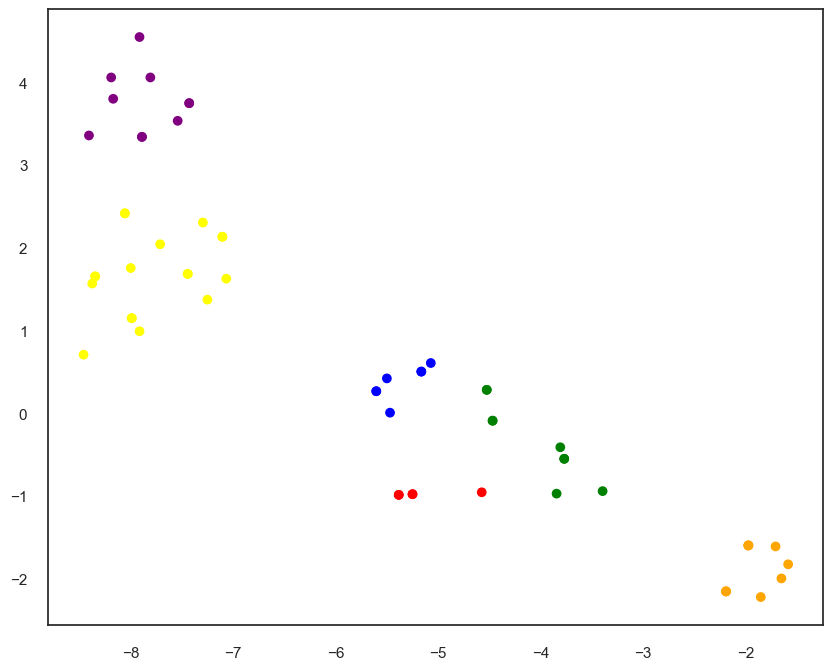

In [105]:
plt.figure(figsize=(10,8))
plt.scatter(transformed_hsi[:,0],transformed_hsi[:,1],c=y_obs_label, cmap=ListedColormap(colors[1:]))


In [106]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [107]:
gm =gm = BayesianGaussianMixture(n_components=6, random_state=0).fit(normalised_hsi)


In [108]:
gm.means_ , gm.covariances_

(array([[ 0.12906035,  0.1155815 ,  0.33734788, ...,  0.77531731,
          0.76816842,  0.84472794],
        [ 0.18750484,  0.28361056, -0.45802284, ..., -1.67492865,
         -1.66013405, -1.68724715],
        [-0.48508197,  0.38624935, -0.18674731, ...,  0.13609434,
          0.28936361, -0.0193617 ],
        [ 0.77918679, -0.00223609,  1.17668411, ...,  0.73870179,
          0.5167549 ,  0.60836502],
        [-0.71043501, -1.38776467, -1.20770212, ..., -0.51419992,
         -0.33558663, -0.44939526],
        [-0.50036014, -0.26659532, -0.80461718, ..., -0.49674434,
         -0.57947882, -0.20890256]]),
 array([[[ 8.07089627e-02,  2.92026420e-02,  2.41252374e-02, ...,
          -4.61119695e-03, -7.86197985e-03, -1.24713396e-02],
         [ 2.92026420e-02,  6.70776355e-02,  8.03313904e-03, ...,
           3.99060374e-03,  1.96382861e-04, -4.70664905e-03],
         [ 2.41252374e-02,  8.03313904e-03,  6.28652615e-02, ...,
          -2.20090474e-03,  1.20987207e-02,  1.51816101e-03],
  

In [109]:
gmm_label = gm.predict(normalised_hsi) +1 
gmm_label

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 6, 6, 6, 3, 3, 3, 3, 6, 6, 5, 5, 5, 5, 5])

In [110]:
y_obs_label

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        1., 1., 1., 1., 1.], dtype=torch.float64)

In [111]:
gmm_label2 = torch.zeros_like(y_obs_label)
gmm_label2[gmm_label==2]=6
gmm_label2[gmm_label==4]=5
gmm_label2[gmm_label==1]=4
gmm_label2[gmm_label==3]=3
gmm_label2[gmm_label==6]=2
gmm_label2[gmm_label==5]=1
gmm_label2

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 3., 3., 3., 3., 2., 2.,
        1., 1., 1., 1., 1.], dtype=torch.float64)

In [115]:
y_obs_label - gmm_label2

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.], dtype=torch.float64)

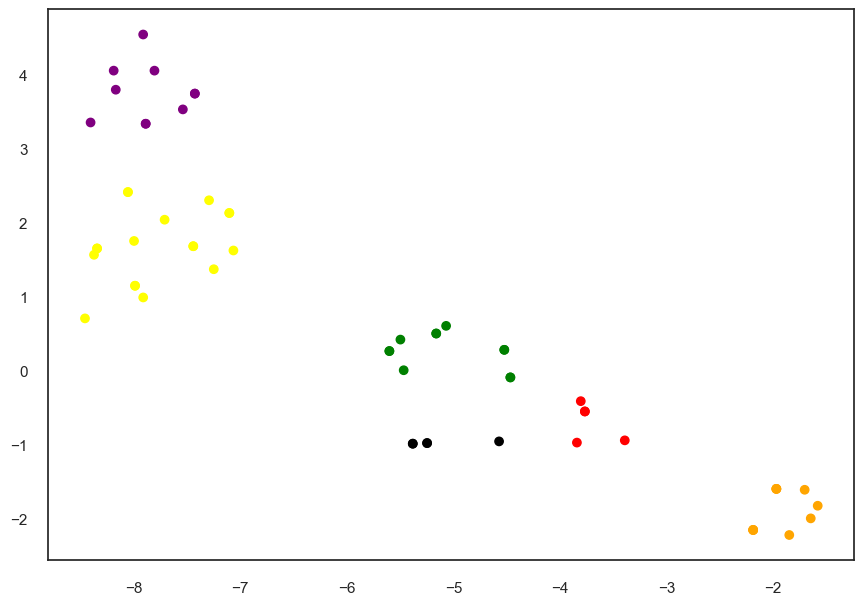

In [118]:
plt.scatter(transformed_hsi[:,0],transformed_hsi[:,1],c=gmm_label2,cmap=ListedColormap(colors))

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


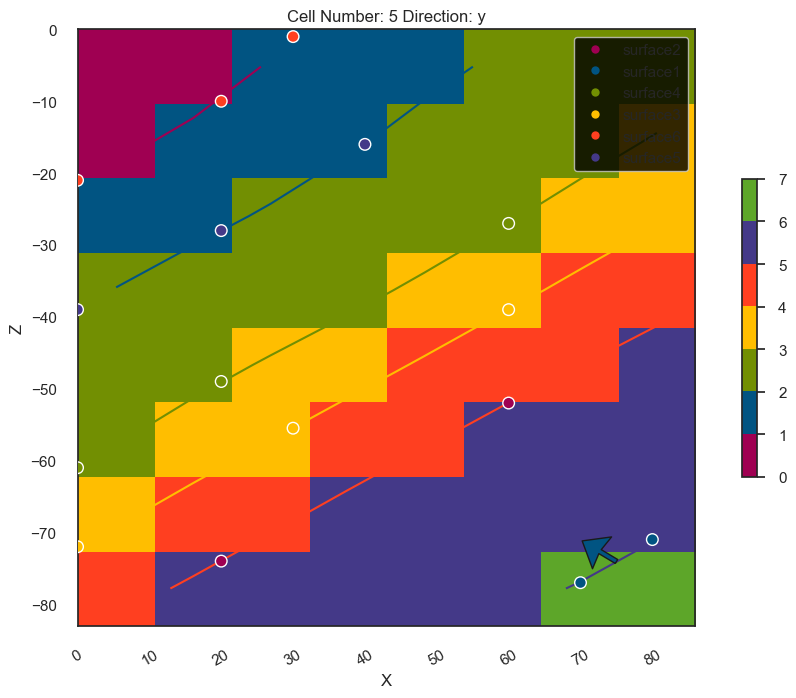

In [66]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

gp.add_surface_points(
    geo_model=geo_model_test,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([200.0, 600.0])/10,
        y=np.array([0.0, 0.0]),
        z=np.array([-740, -520])/10,
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 300.0, 600])/10,
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-720, -830+275, -830+440])/10,
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 200.0, 600])/10,
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-830+220, -830+340, -830+560])/10,
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 200.0, 400])/10,
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([440, 550, 670])/10 -830/10,
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 200.0,300])/10,
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([620, 730, 820])/10 -83,
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element6)

geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1],\
geo_model_test.structural_frame.structural_groups[0].elements[2], geo_model_test.structural_frame.structural_groups[0].elements[3],\
geo_model_test.structural_frame.structural_groups[0].elements[4], geo_model_test.structural_frame.structural_groups[0].elements[5] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0],\
geo_model_test.structural_frame.structural_groups[0].elements[3], geo_model_test.structural_frame.structural_groups[0].elements[2],\
geo_model_test.structural_frame.structural_groups[0].elements[5], geo_model_test.structural_frame.structural_groups[0].elements[4]  

gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')


In [67]:
y_obs_label = 7 -y_obs[mask]
y_obs_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        6., 6., 6., 6., 6.], dtype=torch.float64)

In [68]:
x_loc = 20
y_loc = 0
z_loc = np.linspace(0,-82, 83)
print(z_loc)
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])[mask]
print(xyz_coord.shape)
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

[  0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13.
 -14. -15. -16. -17. -18. -19. -20. -21. -22. -23. -24. -25. -26. -27.
 -28. -29. -30. -31. -32. -33. -34. -35. -36. -37. -38. -39. -40. -41.
 -42. -43. -44. -45. -46. -47. -48. -49. -50. -51. -52. -53. -54. -55.
 -56. -57. -58. -59. -60. -61. -62. -63. -64. -65. -66. -67. -68. -69.
 -70. -71. -72. -73. -74. -75. -76. -77. -78. -79. -80. -81. -82.]
(59, 3)
Active grids: ['custom']


In [69]:
geo_model_test.interpolation_options.mesh_extraction = False
sol = gp.compute_model(geo_model_test)

Setting Backend To: AvailableBackends.numpy


In [70]:
#gpv.plot_2d(geo_model_test, section_names=['section1'])

In [71]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-2.75   0.     0.   ]
 [-0.75   0.     1.1  ]
 [-0.25   0.    -0.15 ]
 [ 0.25   0.     0.15 ]
 [-3.75   0.     0.65 ]
 [-2.75   0.     1.25 ]
 [-0.75   0.     2.35 ]
 [-3.75   0.     0.1  ]
 [-2.25   0.     0.925]
 [-0.75   0.     1.75 ]
 [-3.75   0.     2.65 ]
 [-2.75   0.     3.2  ]
 [-2.25   0.     3.65 ]
 [-3.75   0.     1.75 ]
 [-2.75   0.     2.3  ]
 [-1.75   0.     2.9  ]]


array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

In [72]:
geo_model_test.surface_points

X,Y,Z,id,nugget
20.00,0.00,-74.00,18475018,0.00
60.00,0.00,-52.00,18475018,0.00
70.00,0.00,-77.00,33849191,0.00
80.00,0.00,-71.00,33849191,0.00
0.00,0.00,-61.00,26443819,0.00
20.00,0.00,-49.00,26443819,0.00
60.00,0.00,-27.00,26443819,0.00
0.00,0.00,-72.00,61409462,0.00
30.00,0.00,-55.50,61409462,0.00
60.00,0.00,-39.00,61409462,0.00


Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


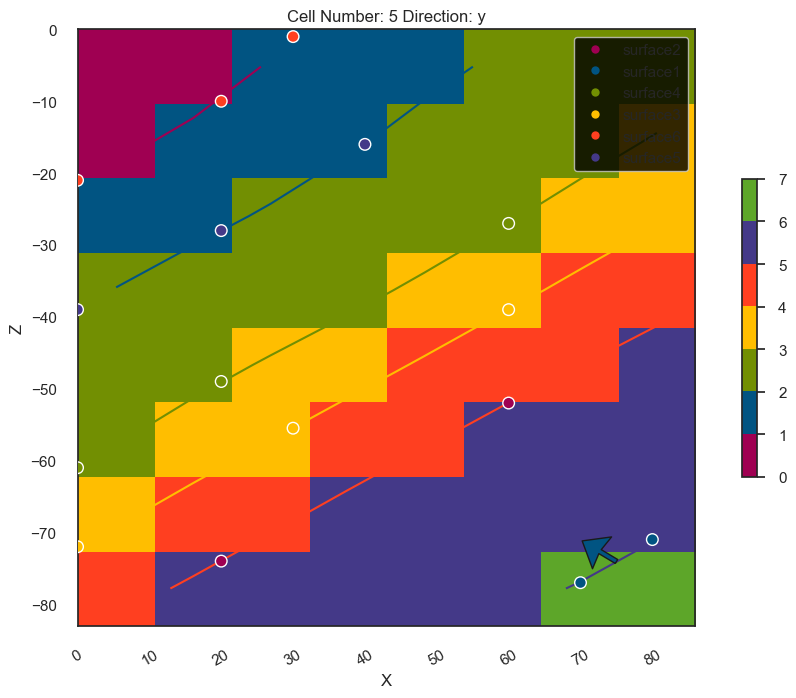

In [73]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [74]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-2.75   0.     0.   ]
 [-0.75   0.     1.1  ]
 [-0.25   0.    -0.15 ]
 [ 0.25   0.     0.15 ]
 [-3.75   0.     0.65 ]
 [-2.75   0.     1.25 ]
 [-0.75   0.     2.35 ]
 [-3.75   0.     0.1  ]
 [-2.25   0.     0.925]
 [-0.75   0.     1.75 ]
 [-3.75   0.     2.65 ]
 [-2.75   0.     3.2  ]
 [-2.25   0.     3.65 ]
 [-3.75   0.     1.75 ]
 [-2.75   0.     2.3  ]
 [-1.75   0.     2.9  ]]


array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

In [75]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

Setting Backend To: AvailableBackends.PYTORCH


In [76]:
# geo_model_test.interpolation_options.uni_degree = 0
# geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 50

In [77]:
geo_model_test.solutions.octrees_output[0].last_output_center

InterpOutput(scalar_fields=ScalarFieldOutput(weights=array([-1.58450258e+00,  4.26719835e-17, -9.07995259e-01,  1.47537823e-02,
       -1.63896301e+00,  7.34936835e-02, -4.24866590e-03, -5.30118658e-02,
        5.72069162e-03, -1.48519490e-01,  1.22845313e-01,  4.64191770e-02,
       -4.14558661e-02, -7.47661279e-01, -2.00597546e-16,  1.31611094e+00]), grid=Grid(regular_grid=RegularGrid(extent=array([-3.749999,  0.550001, -0.499999,  0.500001, -0.449999,  3.700001]), regular_grid_shape=array([2, 2, 2])), custom_grid=GenericGrid(values=array([[-2.75,  0.  ,  3.7 ],
       [-2.75,  0.  ,  3.65],
       [-2.75,  0.  ,  3.6 ],
       [-2.75,  0.  ,  3.55],
       [-2.75,  0.  ,  3.5 ],
       [-2.75,  0.  ,  3.45],
       [-2.75,  0.  ,  3.4 ],
       [-2.75,  0.  ,  3.35],
       [-2.75,  0.  ,  3.3 ],
       [-2.75,  0.  ,  3.25],
       [-2.75,  0.  ,  2.8 ],
       [-2.75,  0.  ,  2.75],
       [-2.75,  0.  ,  2.7 ],
       [-2.75,  0.  ,  2.65],
       [-2.75,  0.  ,  2.6 ],
       [-

In [78]:
custom_grid_values1 = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 6., 6., 6., 6., 6.])

In [79]:
 
# # Compute the geological model
interpolation_input = geo_model_test.interpolation_input
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

# Compute and observe the thickness of the geological layer

custom_grid_values2 = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values

print(custom_grid_values2)

Condition number: 1549.941240198929.
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0032, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0008, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0015, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0014,
        5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0009,
        6.0000, 6.0000, 6.0000, 6.0000, 6.0000], dtype=torch.float64,
       grad_fn=<SliceBackward0>)


In [80]:
torch.tensor(custom_grid_values1) - custom_grid_values2

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.3291e-15,
        -1.0676e-12, -2.1966e-10, -4.8607e-08, -1.1807e-05, -3.2038e-03,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -4.8139e-13, -5.7525e-10, -6.9389e-07, -8.3637e-04,
         6.6285e-10,  6.0396e-13,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -5.3291e-15, -3.9524e-12,
        -2.9621e-09, -2.1426e-06, -1.4905e-03,  1.0658e-14,  0.0000e+00,
        -5.3291e-15, -4.2775e-12, -2.8276e-09, -1.9344e-06, -1.3722e-03,
         2.1831e-12,  2.6645e-15,  0.0000e+00,  0.0000e+00, -8.8818e-16,
        -6.4571e-13, -6.9269e-10, -7.6387e-07, -8.6315e-04,  4.7073e-13,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64, grad_fn=<SubBackward0>)

In [81]:
geo_model_test.surface_points

X,Y,Z,id,nugget
20.00,0.00,-74.00,18475018,0.00
60.00,0.00,-52.00,18475018,0.00
70.00,0.00,-77.00,33849191,0.00
80.00,0.00,-71.00,33849191,0.00
0.00,0.00,-61.00,26443819,0.00
20.00,0.00,-49.00,26443819,0.00
60.00,0.00,-27.00,26443819,0.00
0.00,0.00,-72.00,61409462,0.00
30.00,0.00,-55.50,61409462,0.00
60.00,0.00,-39.00,61409462,0.00


In [82]:
geo_model_test.orientations

X,Y,Z,G_x,G_y,G_z,id,nugget
75.00,0.00,-74.00,-1.67,0.00,1.00,33849191,0.01


In [83]:
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

Condition number: 1556.754505535906.
Condition number: 1556.754505535906.


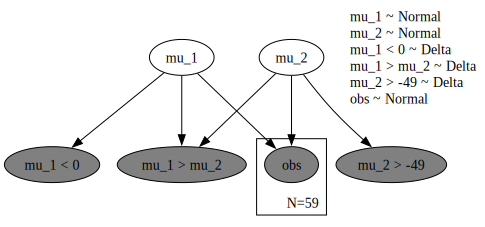

In [84]:

import torch.nn.functional as F
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

@config_enumerate
def model_test(y_obs_label):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[11, 2]
    prior_mean_surface_2 = sp_coords_copy_test[14, 2]

    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.2, dtype=torch.float64)))
    #print(mu_surface_1, mu_surface_2)
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('mu_1 < 0', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 < 3.7))
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    pyro.sample('mu_2 > -49', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > 1.25))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([11]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([14]), torch.tensor([2])),
        mu_surface_2
    )
    
    
    #print("interpolation_input",interpolation_input.surface_points.sp_coords)
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    
    
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        #assignment = pyro.sample("assignment", dist.Categorical(class_label))
        #print("mean\n", mean[assignment])
        obs = pyro.sample("obs", dist.Normal(custom_grid_values, 0.5 ), obs=y_obs_label.reshape(-1))
        #obs = pyro.sample("obs", dist.Normal(sample[assignment], 0.1 ), obs=y_obs_label.reshape(-1))
        #print(obs)
        #obs = pyro.sample("obs", dist.Normal(mean[assignment],  sigma[assignment]), obs=y_obs_label.reshape(-1))
    #return obs
dependencies = get_dependencies(model_test, model_args=(y_obs_label,))
pyro.render_model(model_test, model_args=(y_obs_label,),render_distributions=True)

In [85]:
print(y_obs_label)
model_test(y_obs_label)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        6., 6., 6., 6., 6.], dtype=torch.float64)
Condition number: 1556.7545055359064.


Condition number: 1568.5022046372662.
Condition number: 1545.1270744032486.
Condition number: 1560.0465015422187.
Condition number: 1553.5022895327295.
Condition number: 1529.8198135056361.
Condition number: 1538.698073811973.
Condition number: 1570.1039763838326.
Condition number: 1550.308760134563.
Condition number: 1550.0999891386175.
Condition number: 1549.6909373835633.
Condition number: 1549.0450171380683.
Condition number: 1534.9186977423403.
Condition number: 1543.80359553133.
Condition number: 1559.7054577169229.
Condition number: 1558.8720459309434.
Condition number: 1541.4037146663918.
Condition number: 1549.7183011794139.
Condition number: 1543.6679946849279.
Condition number: 1545.2870784372703.
Condition number: 1546.882737934234.
Condition number: 1574.1821692308938.
Condition number: 1567.6404977583557.
Condition number: 1551.790428540617.
Condition number: 1558.5051097205192.
Condition number: 1564.9267630974753.
Condition number: 1550.0859845940015.
Condition number: 

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


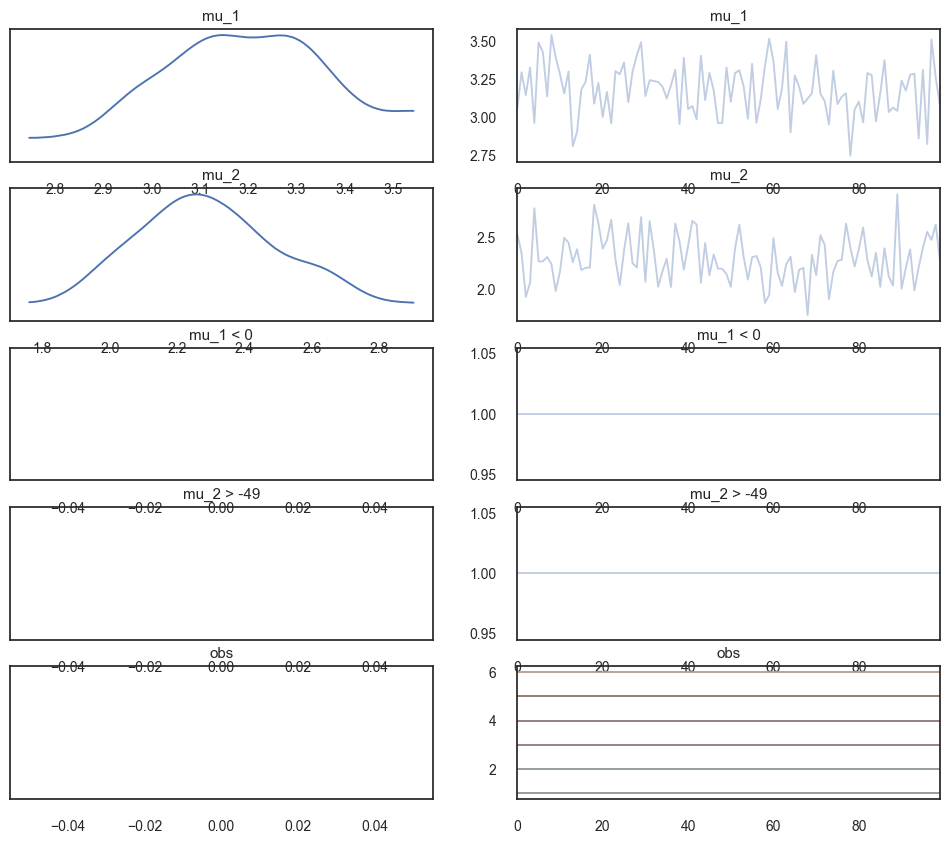

In [86]:
prior = Predictive(model_test, num_samples=100)(y_obs_label)

# Key to avoid
avoid_key = 'mu_1 > mu_2'

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key != avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [87]:
#pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
#nuts_kernel = NUTS(model_test, step_size=0.00085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10)
#nuts_kernel = NUTS(model_test)
#initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
#mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False, initial_params=initial_values)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False)
mcmc.run(y_obs_label)

Warmup:   0%|          | 0/250 [00:00, ?it/s]

Condition number: 1535.9314064993457.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.4125268174014.
Condition number: 1549.941240198929.
Condition number: 1549.5542923422504.
Condition number: 1549.3940942476836.


Warmup:   0%|          | 1/250 [00:00,  1.65it/s, step size=1.29e-01, acc. prob=0.750]

Condition number: 1548.839904703712.
Condition number: 1548.2831462434665.
Condition number: 1550.4771416129206.
Condition number: 1552.7845907095286.
Condition number: 1548.3041746827362.
Condition number: 1548.3325451998942.
Condition number: 1548.367967922147.
Condition number: 1548.4101320737382.
Condition number: 1548.458710254299.
Condition number: 1548.5133624384332.
Condition number: 1548.5737395809372.
Condition number: 1548.2697243819637.
Condition number: 1548.2641436464917.
Condition number: 1548.2666040275103.
Condition number: 1548.2772664008737.
Condition number: 1548.296248088222.
Condition number: 1548.3236185874678.
Condition number: 1548.3593955049819.
Condition number: 1548.4035406928767.
Condition number: 1548.4559565616048.
Condition number: 1548.5164825027314.
Condition number: 1548.5848913257082.
Condition number: 1548.6608855958261.
Condition number: 1548.7440937710924.
Condition number: 1548.8340660910756.
Condition number: 1548.9302702882478.
Condition number

Warmup:   1%|          | 3/250 [00:01,  1.67it/s, step size=1.35e-02, acc. prob=0.583]

Condition number: 1548.7098507985063.
Condition number: 1549.143552484418.
Condition number: 1549.5684576258532.
Condition number: 1547.825740893215.
Condition number: 1547.3806386145275.
Condition number: 1546.9372974366638.
Condition number: 1546.4987067520417.
Condition number: 1546.0679309370373.
Condition number: 1545.6480731386023.
Condition number: 1545.242238106525.
Condition number: 1544.8534948211832.
Condition number: 1544.484839649273.
Condition number: 1544.139160712237.
Condition number: 1543.8192040812226.
Condition number: 1543.5275423803728.
Condition number: 1543.2665466251299.
Condition number: 1543.0383630593158.
Condition number: 1542.8448979972368.


Warmup:   2%|▏         | 4/250 [00:02,  1.48it/s, step size=1.50e-02, acc. prob=0.687]

Condition number: 1542.6878123677468.
Condition number: 1542.5685205150705.
Condition number: 1542.4881786846358.
Condition number: 1542.4476495926099.
Condition number: 1542.44744641422.
Condition number: 1545.3357146227997.
Condition number: 1545.8467194152377.
Condition number: 1546.3832623243875.
Condition number: 1546.9418001854901.
Condition number: 1547.5183568243347.
Condition number: 1548.1079552646086.
Condition number: 1548.7025886795411.
Condition number: 1544.4030300914078.
Condition number: 1543.9870042944835.
Condition number: 1543.6078006434268.
Condition number: 1543.2674886372592.
Condition number: 1542.9678140660799.
Condition number: 1542.7101926161015.
Condition number: 1542.4957073515677.
Condition number: 1542.3251103282746.
Condition number: 1549.2849621371558.
Condition number: 1549.8143615304054.
Condition number: 1550.2158229945564.
Condition number: 1550.418159086702.
Condition number: 1550.431198045009.
Condition number: 1550.3406907360963.
Condition number

Warmup:   2%|▏         | 5/250 [00:03,  1.33it/s, step size=1.62e-02, acc. prob=0.742]

Condition number: 1550.0707350852506.
Condition number: 1549.9181264761562.
Condition number: 1549.7564319881642.
Condition number: 1549.586441667873.
Condition number: 1549.4090790600237.
Condition number: 1542.183940823542.


Warmup:   2%|▏         | 6/250 [00:03,  1.70it/s, step size=2.06e-02, acc. prob=0.785]

Condition number: 1541.455684298248.
Condition number: 1540.7882812848939.
Condition number: 1540.1881923094884.
Condition number: 1539.6738975057208.
Condition number: 1539.3222180320454.
Condition number: 1539.3056188390103.
Condition number: 1537.6048446986358.
Condition number: 1541.6299825046274.
Condition number: 1544.0240944215357.
Condition number: 1546.454522114856.
Condition number: 1548.8896240134404.
Condition number: 1551.2986382832635.
Condition number: 1553.616642664483.
Condition number: 1537.1628672961178.
Condition number: 1537.9502270370774.
Condition number: 1539.1015190033668.
Condition number: 1540.3809218571228.
Condition number: 1541.8185397001632.


Warmup:   3%|▎         | 7/250 [00:04,  1.77it/s, step size=1.50e-02, acc. prob=0.789]

Condition number: 1543.4536703673934.
Condition number: 1545.2507712789604.
Condition number: 1546.9358489995448.
Condition number: 1537.255489421467.
Condition number: 1537.728310129097.
Condition number: 1538.6748360648098.
Condition number: 1539.7145250347494.
Condition number: 1540.8171669984226.
Condition number: 1541.9779925912183.
Condition number: 1543.194733704128.
Condition number: 1544.464184472028.
Condition number: 1545.7624116305367.
Condition number: 1546.976521650734.
Condition number: 1547.954986289496.
Condition number: 1548.623611030786.


Warmup:   3%|▎         | 8/250 [00:04,  1.68it/s, step size=2.01e-02, acc. prob=0.815]

Condition number: 1548.948474866993.
Condition number: 1548.9125093110297.
Condition number: 1548.5108235064372.
Condition number: 1546.6336784846292.
Condition number: 1547.1499533213332.
Condition number: 1547.2168348332564.


Warmup:   4%|▎         | 9/250 [00:05,  2.04it/s, step size=2.59e-02, acc. prob=0.834]

Condition number: 1544.7421622579757.
Condition number: 1543.7526645807693.
Condition number: 1542.8336716898434.
Condition number: 1541.9888570678481.
Condition number: 1542.2618765632328.
Condition number: 1541.787125793985.


Warmup:   4%|▍         | 10/250 [00:05,  2.38it/s, step size=3.47e-02, acc. prob=0.850]

Condition number: 1541.4041416738464.
Condition number: 1543.5084431345288.
Condition number: 1544.3207744773406.
Condition number: 1545.2357236474654.
Condition number: 1545.9731182614794.
Condition number: 1539.9918928805316.
Condition number: 1541.477085687154.
Condition number: 1543.3417620913096.
Condition number: 1543.0654174787408.
Condition number: 1544.9298237133883.
Condition number: 1546.9494313261987.
Condition number: 1548.9253762708342.
Condition number: 1548.8940786490218.
Condition number: 1546.8763295053534.
Condition number: 1544.8667648522865.
Condition number: 1543.008972680517.
Condition number: 1541.3501258431709.
Condition number: 1539.9435349498574.


Warmup:   4%|▍         | 11/250 [00:06,  2.19it/s, step size=4.15e-02, acc. prob=0.859]

Condition number: 1542.6898990058692.
Condition number: 1545.6349019469965.
Condition number: 1545.9715877587605.
Condition number: 1547.2725279597203.
Condition number: 1548.5731211643874.
Condition number: 1548.7017531517006.


Warmup:   5%|▍         | 12/250 [00:06,  2.56it/s, step size=5.70e-02, acc. prob=0.871]

Condition number: 1548.266735066161.
Condition number: 1547.8542508912349.
Condition number: 1547.4784569538238.
Condition number: 1545.1869076886921.
Condition number: 1549.9638113215638.
Condition number: 1552.3718748505898.


Warmup:   5%|▌         | 13/250 [00:06,  3.27it/s, step size=3.77e-02, acc. prob=0.863]

Condition number: 1544.9944661879993.
Condition number: 1545.5208427307275.
Condition number: 1545.989762171495.
Condition number: 1544.947551559771.
Condition number: 1545.0472500202782.
Condition number: 1544.837628179218.
Condition number: 1544.7816928869686.


Warmup:   6%|▌         | 15/250 [00:06,  3.98it/s, step size=3.82e-02, acc. prob=0.868]

Condition number: 1548.041217970483.
Condition number: 1543.265374904853.
Condition number: 1541.4463800792787.
Condition number: 1550.642400028701.
Condition number: 1553.1405117651989.
Condition number: 1539.2880112714236.


Warmup:   6%|▋         | 16/250 [00:06,  4.22it/s, step size=2.67e-02, acc. prob=0.862]

Condition number: 1543.9499664863738.
Condition number: 1546.6634040902284.
Condition number: 1549.4761086993549.
Condition number: 1552.2751907032462.
Condition number: 1551.7170008586845.
Condition number: 1542.2130680091657.
Condition number: 1545.796885253023.


Warmup:   7%|▋         | 17/250 [00:07,  4.21it/s, step size=2.82e-02, acc. prob=0.865]

Condition number: 1547.7179353781837.
Condition number: 1540.6213563263964.
Condition number: 1539.6603885846882.
Condition number: 1541.1777433878353.
Condition number: 1542.890279479439.
Condition number: 1546.5432710406185.
Condition number: 1548.938813485871.
Condition number: 1550.1804285741737.
Condition number: 1551.3930092485252.
Condition number: 1551.4863939254305.
Condition number: 1550.656394061965.
Condition number: 1549.790277503577.
Condition number: 1545.4389756903265.
Condition number: 1544.427490423188.
Condition number: 1543.5290673129505.
Condition number: 1542.761405227097.
Condition number: 1542.140238450558.
Condition number: 1541.6982248847214.
Condition number: 1541.62694897235.


Warmup:   8%|▊         | 19/250 [00:07,  3.53it/s, step size=4.67e-02, acc. prob=0.877]

Condition number: 1542.121156967372.
Condition number: 1549.7036111394743.
Condition number: 1550.9850633837311.
Condition number: 1549.952409868976.
Condition number: 1549.760269423862.
Condition number: 1549.998795822243.
Condition number: 1550.9819246961765.
Condition number: 1551.7066487949155.
Condition number: 1551.8333757993028.
Condition number: 1548.4945771982032.
Condition number: 1547.2360018744096.


Warmup:   8%|▊         | 21/250 [00:08,  4.43it/s, step size=1.84e-02, acc. prob=0.864]

Condition number: 1545.9923134973135.
Condition number: 1544.7705135557317.
Condition number: 1547.500406560901.
Condition number: 1547.786433501287.
Condition number: 1548.0910376515087.
Condition number: 1546.9959976850628.
Condition number: 1546.7828675678504.
Condition number: 1546.5987474855385.
Condition number: 1546.4454086541318.
Condition number: 1546.324236825.
Condition number: 1546.2362183780922.
Condition number: 1546.1819334446116.
Condition number: 1546.1615561214787.
Condition number: 1546.1748616928655.
Condition number: 1546.221240628607.
Condition number: 1546.2997189823925.
Condition number: 1546.4089846627048.
Condition number: 1546.5474189004012.
Condition number: 1546.713132093456.
Condition number: 1546.9040030807828.
Condition number: 1547.1177207918586.
Condition number: 1547.3518271452303.
Condition number: 1547.603760033803.
Condition number: 1547.8708952396073.
Condition number: 1548.1505861596638.


Warmup:   9%|▉         | 22/250 [00:09,  2.62it/s, step size=2.23e-02, acc. prob=0.869]

Condition number: 1548.4402001904193.
Condition number: 1548.737148637107.
Condition number: 1546.7243575312866.
Condition number: 1547.251427788591.
Condition number: 1547.8090147694393.
Condition number: 1548.3883140068408.
Condition number: 1548.9803259884839.
Condition number: 1549.576042325533.
Condition number: 1550.1665871344508.
Condition number: 1545.794844782399.
Condition number: 1545.4073146667477.
Condition number: 1545.079791833678.
Condition number: 1544.8173918473958.


Warmup:   9%|▉         | 23/250 [00:09,  2.41it/s, step size=3.04e-02, acc. prob=0.874]

Condition number: 1544.624074789944.
Condition number: 1544.502567368017.
Condition number: 1544.4543160205978.
Condition number: 1544.4794719337524.
Condition number: 1548.5358271519553.
Condition number: 1548.1253383939586.
Condition number: 1547.7580693367888.
Condition number: 1549.4485542292782.
Condition number: 1549.9289060617807.
Condition number: 1550.4054610363437.
Condition number: 1550.8413639835578.
Condition number: 1551.130823771499.
Condition number: 1551.1456461687444.
Condition number: 1550.9818975056255.
Condition number: 1550.7550366576936.
Condition number: 1550.5000250657965.
Condition number: 1550.2270665414326.


Warmup:  10%|▉         | 24/250 [00:10,  2.23it/s, step size=3.35e-02, acc. prob=0.877]

Condition number: 1549.9428109168596.
Condition number: 1548.9821715643054.
Condition number: 1548.056661798113.
Condition number: 1547.182302103803.
Condition number: 1546.386964930595.
Condition number: 1545.6956802428804.
Condition number: 1545.1296825599711.
Condition number: 1544.7056365970805.
Condition number: 1550.860984370349.
Condition number: 1551.6692005305313.
Condition number: 1551.8013351975162.


Warmup:  10%|█         | 25/250 [00:10,  2.23it/s, step size=3.47e-02, acc. prob=0.878]

Condition number: 1551.5748980534206.
Condition number: 1544.311898952639.
Condition number: 1546.09342728432.
Condition number: 1547.1683521820814.
Condition number: 1548.3161517540718.
Condition number: 1549.4968193371105.
Condition number: 1550.6704155628006.
Condition number: 1551.7954086911614.
Condition number: 1543.6696631274524.
Condition number: 1543.2259567604933.
Condition number: 1542.9960881729626.


Warmup:  11%|█         | 27/250 [00:11,  2.78it/s, step size=2.45e-02, acc. prob=0.874]

Condition number: 1542.987023241185.
Condition number: 1548.9055752628767.
Condition number: 1547.7810438212932.
Condition number: 1547.3212611698123.
Condition number: 1547.534925462049.
Condition number: 1546.182023340278.


Warmup:  11%|█         | 28/250 [00:11,  2.96it/s, step size=2.16e-02, acc. prob=0.874]

Condition number: 1544.8727342324125.
Condition number: 1550.2676240864866.
Condition number: 1551.5758016167974.
Condition number: 1552.3578876585525.
Condition number: 1551.817444874402.
Condition number: 1544.5185485715601.
Condition number: 1544.1567275044179.
Condition number: 1543.805545592415.
Condition number: 1545.2018715159327.
Condition number: 1545.4913042076714.
Condition number: 1545.7301481084962.
Condition number: 1545.911991427947.
Condition number: 1545.8979153723494.
Condition number: 1545.799124504763.


Warmup:  12%|█▏        | 29/250 [00:12,  2.52it/s, step size=2.34e-02, acc. prob=0.875]

Condition number: 1545.5706270731396.
Condition number: 1545.3091984788637.
Condition number: 1547.0272511470055.
Condition number: 1544.0132030551517.
Condition number: 1542.6137247568468.


Warmup:  12%|█▏        | 30/250 [00:12,  2.76it/s, step size=2.60e-02, acc. prob=0.877]

Condition number: 1548.5994075862643.
Condition number: 1550.1855676421528.
Condition number: 1551.619548167915.
Condition number: 1551.4508054758055.
Condition number: 1542.261129527479.
Condition number: 1543.111501914521.
Condition number: 1543.7268919226228.
Condition number: 1544.4463987469062.
Condition number: 1545.2575028381418.
Condition number: 1546.1464293757613.
Condition number: 1547.0981575431608.


Warmup:  12%|█▏        | 31/250 [00:12,  2.89it/s, step size=2.35e-02, acc. prob=0.877]

Condition number: 1543.1562598706203.
Condition number: 1543.1629908565267.
Condition number: 1543.309186590205.
Condition number: 1543.5474344482504.
Condition number: 1543.874314752719.
Condition number: 1544.285460478152.
Condition number: 1544.7753973021024.
Condition number: 1543.2967321108106.
Condition number: 1543.5299970088327.
Condition number: 1543.851627060779.
Condition number: 1544.2565031263296.


Warmup:  13%|█▎        | 32/250 [00:13,  2.35it/s, step size=2.61e-02, acc. prob=0.878]

Condition number: 1544.7388599909634.
Condition number: 1545.2920885226445.
Condition number: 1545.9086499724303.
Condition number: 1546.5799561066603.
Condition number: 1543.8193559854888.
Condition number: 1544.8412298049786.
Condition number: 1545.4760700679997.
Condition number: 1543.4523211567189.
Condition number: 1543.1923155266823.
Condition number: 1543.0455894364125.
Condition number: 1543.0164274711951.


Warmup:  13%|█▎        | 33/250 [00:13,  2.48it/s, step size=2.57e-02, acc. prob=0.879]

Condition number: 1546.1784485655885.
Condition number: 1546.936127233244.
Condition number: 1542.2679273884105.
Condition number: 1543.8489101722735.
Condition number: 1544.7567130361185.
Condition number: 1545.7307048343528.
Condition number: 1546.7608698436852.
Condition number: 1547.8085085787407.
Condition number: 1548.3611493734181.
Condition number: 1541.6207828799534.
Condition number: 1541.896499934727.
Condition number: 1543.6173737000584.


Warmup:  14%|█▎        | 34/250 [00:14,  2.39it/s, step size=2.65e-02, acc. prob=0.879]

Condition number: 1545.4186182168778.
Condition number: 1546.8526550269867.
Condition number: 1548.3661651207017.
Condition number: 1549.379422978839.
Condition number: 1549.124486815594.
Condition number: 1545.192982200259.


Warmup:  14%|█▍        | 35/250 [00:14,  2.68it/s, step size=3.41e-02, acc. prob=0.883]

Condition number: 1543.719983324673.
Condition number: 1542.3672567605404.
Condition number: 1541.1567387867156.
Condition number: 1545.4591504016369.
Condition number: 1542.0698946461255.
Condition number: 1540.6004943464238.


Warmup:  14%|█▍        | 36/250 [00:14,  3.05it/s, step size=2.90e-02, acc. prob=0.881]

Condition number: 1547.1978007229175.
Condition number: 1548.855540650905.
Condition number: 1550.3684240517898.
Condition number: 1539.2862235865575.
Condition number: 1536.7820400218525.
Condition number: 1536.649945189507.


Warmup:  15%|█▍        | 37/250 [00:14,  3.76it/s, step size=3.43e-02, acc. prob=0.883]

Condition number: 1539.9043487678327.
Condition number: 1543.5013137659057.
Condition number: 1547.3109848122795.
Condition number: 1550.2543989007368.
Condition number: 1551.097875003943.
Condition number: 1549.6770071476535.


Warmup:  15%|█▌        | 38/250 [00:14,  3.70it/s, step size=4.33e-02, acc. prob=0.886]

Condition number: 1545.930783283979.
Condition number: 1550.680694364292.
Condition number: 1550.5838601698074.


Warmup:  16%|█▌        | 39/250 [00:15,  3.74it/s, step size=2.77e-02, acc. prob=0.882]

Condition number: 1547.0163213592155.
Condition number: 1546.3614322338046.
Condition number: 1545.612501471355.
Condition number: 1544.8782419128456.
Condition number: 1544.2347542201867.
Condition number: 1543.7197602662086.
Condition number: 1543.3465343042665.
Condition number: 1543.1170660240894.
Condition number: 1547.4975047926487.
Condition number: 1547.8335407827917.
Condition number: 1548.1143771908007.
Condition number: 1548.381516685935.


Warmup:  16%|█▌        | 40/250 [00:15,  2.90it/s, step size=3.05e-02, acc. prob=0.883]

Condition number: 1548.6321465657663.
Condition number: 1548.854417916765.
Condition number: 1549.0387008810135.
Condition number: 1549.1794324859723.
Condition number: 1544.7701724807796.
Condition number: 1542.0989213144912.
Condition number: 1541.0674377868904.
Condition number: 1540.2839552908713.
Condition number: 1539.7648449624603.
Condition number: 1539.515762050833.
Condition number: 1539.5442551086956.
Condition number: 1546.3228194763471.
Condition number: 1547.9309290709275.
Condition number: 1549.3625379780717.
Condition number: 1549.9614129932156.
Condition number: 1549.9688192220997.
Condition number: 1549.8738830942564.


Warmup:  17%|█▋        | 42/250 [00:16,  3.15it/s, step size=4.26e-02, acc. prob=0.887]

Condition number: 1549.6978566757475.
Condition number: 1541.1690710588884.
Condition number: 1539.7007647755613.
Condition number: 1539.4932897765607.
Condition number: 1539.2312766283749.
Condition number: 1543.5422561371029.


Warmup:  17%|█▋        | 43/250 [00:16,  3.34it/s, step size=5.45e-02, acc. prob=0.889]

Condition number: 1546.2093803100872.
Condition number: 1537.8824837872273.
Condition number: 1537.7258926573254.
Condition number: 1539.2125521651064.
Condition number: 1541.3073623069638.
Condition number: 1549.3838194500136.
Condition number: 1552.2800851376408.
Condition number: 1547.9325197197497.
Condition number: 1549.3838194500136.
Condition number: 1549.3838194500136.
Condition number: 1549.413275885109.
Condition number: 1549.3838194500136.
Condition number: 1549.278129511711.
Condition number: 1549.3838194500136.
Condition number: 1549.084869616384.
Condition number: 1549.3838194500136.
Condition number: 1549.2220562148175.
Condition number: 1549.3838194500136.
Condition number: 1548.4776618729966.


Warmup:  18%|█▊        | 44/250 [00:17,  2.55it/s, step size=1.54e+00, acc. prob=0.882]

Condition number: 1549.3838194500136.
Condition number: 1547.479537564223.
Condition number: 1549.3838194500136.
Condition number: 1549.5419900320144.
Condition number: 1545.9793701809201.
Condition number: 1525.984504318721.
Condition number: 1548.7811831134125.
Condition number: 1550.0403651924153.
Condition number: 1550.582736004677.
Condition number: 1548.2498457063841.


Warmup:  19%|█▉        | 47/250 [00:17,  3.94it/s, step size=3.91e-01, acc. prob=0.854]

Condition number: 1547.7875826424367.
Condition number: 1547.3873671655283.
Condition number: 1547.0399174250622.
Condition number: 1548.1595598776398.
Condition number: 1546.585750541043.
Condition number: 1545.793623218492.


Warmup:  19%|█▉        | 48/250 [00:17,  4.36it/s, step size=1.95e-01, acc. prob=0.852]

Condition number: 1548.8722091436857.
Condition number: 1546.215528325228.
Condition number: 1546.9727192576433.
Condition number: 1547.3738855233544.
Condition number: 1545.864468031393.
Condition number: 1545.534812667727.
Condition number: 1545.2285970398202.
Condition number: 1544.9476159179437.
Condition number: 1544.693396897687.
Condition number: 1544.4671785541627.
Condition number: 1544.269894350766.
Condition number: 1544.1021626244628.
Condition number: 1543.9642828330977.
Condition number: 1543.8562381163838.
Condition number: 1543.777704090254.
Condition number: 1543.728063662448.
Condition number: 1547.7866078542042.
Condition number: 1548.2081942777684.
Condition number: 1548.6359442839798.
Condition number: 1549.0671894969582.
Condition number: 1549.4993318271988.
Condition number: 1549.929877656685.
Condition number: 1550.356465236372.


Warmup:  20%|█▉        | 49/250 [00:18,  2.65it/s, step size=3.59e-01, acc. prob=0.854]

Condition number: 1550.7768671723172.
Condition number: 1551.1886776816366.
Condition number: 1543.3510585871904.
Condition number: 1545.2532219720363.
Condition number: 1546.3132042900395.
Condition number: 1547.4600613067864.


Warmup:  20%|██        | 50/250 [00:18,  2.90it/s, step size=3.59e-01, acc. prob=0.857]

Condition number: 1548.665387720614.
Condition number: 1549.4907240595082.
Condition number: 1549.7306543946452.
Condition number: 1544.7193741283004.
Condition number: 1544.280362244935.
Condition number: 1543.9695478277204.


Warmup:  20%|██        | 51/250 [00:19,  3.11it/s, step size=3.59e-01, acc. prob=0.856]

Condition number: 1545.8452754978734.
Condition number: 1546.458822064318.
Condition number: 1547.060280345689.
Condition number: 1547.6220358342764.
Condition number: 1544.6098485430743.
Condition number: 1545.0758265163443.
Condition number: 1545.6586089582875.
Condition number: 1546.3329583338666.
Condition number: 1547.0699572138203.
Condition number: 1547.8392152837464.
Condition number: 1548.6112044446684.


Sample:  21%|██        | 52/250 [00:19,  2.84it/s, step size=3.59e-01, acc. prob=0.872]

Condition number: 1549.3594655212833.
Condition number: 1550.0624159863546.
Condition number: 1547.2468147071565.
Condition number: 1547.4895105246794.
Condition number: 1547.7923998973538.
Condition number: 1546.9617390161918.
Condition number: 1546.9220011406128.
Condition number: 1546.9477150769885.
Condition number: 1547.033271546728.
Condition number: 1547.1709434405393.
Condition number: 1547.351483542803.
Condition number: 1547.5648044077548.
Condition number: 1547.8006782645764.


Sample:  21%|██        | 53/250 [00:20,  2.63it/s, step size=3.59e-01, acc. prob=0.889]

Condition number: 1548.0493910586727.
Condition number: 1548.302279808397.
Condition number: 1546.1529849738374.
Condition number: 1545.3410282744046.
Condition number: 1544.6094238871822.
Condition number: 1543.967462397733.
Condition number: 1543.4214215726092.
Condition number: 1542.9744813899144.
Condition number: 1542.6268615689476.
Condition number: 1542.3763294472865.
Condition number: 1542.2198813335103.
Condition number: 1542.1594948868114.


Sample:  22%|██▏       | 54/250 [00:20,  2.35it/s, step size=3.59e-01, acc. prob=0.917]

Condition number: 1542.2157614190653.
Condition number: 1542.431631217975.
Condition number: 1542.8180406314386.
Condition number: 1543.3211216565937.
Condition number: 1543.881464718109.
Condition number: 1543.2168305998714.
Condition number: 1544.287348317686.
Condition number: 1545.424393357399.
Condition number: 1541.3762977102624.
Condition number: 1541.9716444364503.
Condition number: 1543.5724556090668.
Condition number: 1545.224084133127.


Sample:  22%|██▏       | 55/250 [00:20,  2.65it/s, step size=3.59e-01, acc. prob=0.915]

Condition number: 1543.0507340436843.
Condition number: 1542.5836878288471.
Condition number: 1542.1947454369854.
Condition number: 1541.9042738282706.
Condition number: 1541.723113953633.
Condition number: 1541.6555261656679.
Condition number: 1541.705208881601.
Condition number: 1541.876910122473.
Condition number: 1542.1746826842789.
Condition number: 1542.5998230641999.
Condition number: 1543.1496553876905.
Condition number: 1543.8171176044523.
Condition number: 1544.5908862681435.
Condition number: 1545.4558672908286.
Condition number: 1546.3939605572464.
Condition number: 1544.1274089766246.
Condition number: 1544.2998433373773.
Condition number: 1544.4618640722642.
Condition number: 1544.6583890340455.
Condition number: 1544.8927107387394.
Condition number: 1545.168356161412.
Condition number: 1545.4893901759744.
Condition number: 1545.8600057593537.
Condition number: 1546.2840282970976.
Condition number: 1546.7643867068118.


Sample:  22%|██▏       | 56/250 [00:21,  1.69it/s, step size=3.59e-01, acc. prob=0.929]

Condition number: 1547.3026019466856.
Condition number: 1547.8983405792121.
Condition number: 1548.5490561667248.
Condition number: 1549.2493902832568.
Condition number: 1549.9853803866263.
Condition number: 1550.6810441521081.
Condition number: 1548.1587221341201.
Condition number: 1547.809936277385.
Condition number: 1547.49735318555.
Condition number: 1547.2149332478477.
Condition number: 1546.9566514766525.
Condition number: 1546.7171246772727.
Condition number: 1546.492106094416.
Condition number: 1546.2773529273043.
Condition number: 1545.903311089268.
Condition number: 1545.2272662359424.


Sample:  23%|██▎       | 57/250 [00:22,  1.76it/s, step size=3.59e-01, acc. prob=0.935]

Condition number: 1544.566840844462.
Condition number: 1546.8054269651793.
Condition number: 1546.432471396223.
Condition number: 1546.0959538274888.
Condition number: 1547.660633626287.
Condition number: 1548.1415045524295.
Condition number: 1548.6556748855864.
Condition number: 1549.2002759638283.
Condition number: 1549.7712640986188.
Condition number: 1550.3621627140658.
Condition number: 1550.9501878392794.
Condition number: 1551.4043660916404.


Sample:  23%|██▎       | 58/250 [00:23,  1.80it/s, step size=3.59e-01, acc. prob=0.943]

Condition number: 1551.420669892434.
Condition number: 1551.11191825203.
Condition number: 1550.740620514636.
Condition number: 1550.358535474975.
Condition number: 1550.5730418169974.
Condition number: 1548.064211258039.


Sample:  24%|██▍       | 60/250 [00:23,  2.74it/s, step size=3.59e-01, acc. prob=0.838]

Condition number: 1548.0174089429665.
Condition number: 1548.0110952430507.
Condition number: 1548.238945494123.
Condition number: 1548.3466350129654.
Condition number: 1548.4558027172295.
Condition number: 1547.15590488568.


Sample:  24%|██▍       | 61/250 [00:23,  3.06it/s, step size=3.59e-01, acc. prob=0.834]

Condition number: 1546.2610722045065.
Condition number: 1545.387058377933.
Condition number: 1548.7650134918642.
Condition number: 1549.370230812075.
Condition number: 1545.9998987391464.
Condition number: 1544.8854656553442.
Condition number: 1544.633563638495.
Condition number: 1544.7498167462575.
Condition number: 1545.165298365365.
Condition number: 1545.7219718599206.
Condition number: 1546.3665284688182.


Sample:  25%|██▍       | 62/250 [00:23,  3.22it/s, step size=3.59e-01, acc. prob=0.847]

Condition number: 1545.8215514524852.
Condition number: 1545.401296689709.
Condition number: 1545.0998293254488.
Condition number: 1544.9048993398692.
Condition number: 1544.7996487016076.
Condition number: 1544.7643253504.
Condition number: 1544.7781889772843.
Condition number: 1547.032429950512.
Condition number: 1547.794425880189.
Condition number: 1548.5779485935316.
Condition number: 1549.236987977649.
Condition number: 1549.6383009744977.


Sample:  25%|██▌       | 63/250 [00:24,  2.67it/s, step size=3.59e-01, acc. prob=0.859]

Condition number: 1549.820390876826.
Condition number: 1549.9291495990012.
Condition number: 1550.0053689413648.
Condition number: 1549.450399773521.
Condition number: 1550.1456663889346.
Condition number: 1550.12739051735.
Condition number: 1549.6367511267458.
Condition number: 1548.9463928620162.
Condition number: 1548.2753268451415.
Condition number: 1547.6665951572693.
Condition number: 1549.0940899724776.
Condition number: 1548.7465808167822.


Sample:  26%|██▌       | 64/250 [00:24,  2.65it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1548.4002271008874.
Condition number: 1548.0490319007295.
Condition number: 1548.8652139767091.
Condition number: 1549.0251717896547.
Condition number: 1549.116533904552.
Condition number: 1548.7127748929252.


Sample:  26%|██▌       | 65/250 [00:24,  2.91it/s, step size=3.59e-01, acc. prob=0.871]

Condition number: 1548.4306110774914.
Condition number: 1548.0498640998655.
Condition number: 1547.6600703670185.
Condition number: 1548.6134810106805.
Condition number: 1548.3682054016226.
Condition number: 1547.9396344037164.


Sample:  26%|██▋       | 66/250 [00:25,  3.59it/s, step size=3.59e-01, acc. prob=0.855]

Condition number: 1547.9555121819226.
Condition number: 1547.3349450222913.
Condition number: 1546.781587476792.


Sample:  27%|██▋       | 67/250 [00:25,  3.18it/s, step size=3.59e-01, acc. prob=0.855]

Condition number: 1549.2782109379516.
Condition number: 1549.9207422858947.
Condition number: 1550.516211302979.
Condition number: 1551.0455285231649.
Condition number: 1545.8409874944862.
Condition number: 1547.828651454335.
Condition number: 1548.9315055353.
Condition number: 1545.0261890951108.
Condition number: 1544.346011522607.
Condition number: 1543.8018799613712.
Condition number: 1543.3885768818218.
Condition number: 1549.9224106852698.
Condition number: 1550.481674616963.
Condition number: 1550.542955856736.
Condition number: 1550.457878919227.
Condition number: 1550.3211699795381.


Sample:  27%|██▋       | 68/250 [00:26,  2.62it/s, step size=3.59e-01, acc. prob=0.859]

Condition number: 1550.1260188562974.
Condition number: 1542.5360095751344.
Condition number: 1540.8887485742496.
Condition number: 1539.4264746934243.
Condition number: 1538.214126803617.
Condition number: 1538.0084529409437.
Condition number: 1539.0231769694524.


Sample:  28%|██▊       | 69/250 [00:26,  2.30it/s, step size=3.59e-01, acc. prob=0.866]

Condition number: 1540.846807756125.
Condition number: 1538.799559685785.
Condition number: 1540.2656728823301.
Condition number: 1541.289322710364.
Condition number: 1539.1668451336895.
Condition number: 1540.8138523012597.


Sample:  28%|██▊       | 70/250 [00:26,  2.36it/s, step size=3.59e-01, acc. prob=0.866]

Condition number: 1542.874178783764.
Condition number: 1544.947698196144.
Condition number: 1546.9930177299702.
Condition number: 1544.6915573231934.
Condition number: 1545.2469318178205.
Condition number: 1545.590329024413.
Condition number: 1544.4774495352838.
Condition number: 1544.3035034018642.
Condition number: 1544.1512294132715.


Sample:  28%|██▊       | 71/250 [00:27,  2.57it/s, step size=3.59e-01, acc. prob=0.873]

Condition number: 1543.9043238873585.
Condition number: 1544.1270444708307.
Condition number: 1543.0689148741415.
Condition number: 1542.0867678651332.
Condition number: 1546.4178356223767.
Condition number: 1547.6282570681701.
Condition number: 1548.866049372084.
Condition number: 1550.1185813131938.
Condition number: 1551.372852888422.
Condition number: 1552.5854379286625.
Condition number: 1552.5088831705036.
Condition number: 1551.3604841610488.


Sample:  29%|██▉       | 72/250 [00:27,  2.50it/s, step size=3.59e-01, acc. prob=0.878]

Condition number: 1544.2535711524772.
Condition number: 1545.498220983627.
Condition number: 1546.7942422624847.
Condition number: 1548.1322578014117.
Condition number: 1549.5020691041668.
Condition number: 1550.892325123758.
Condition number: 1552.1324619864067.
Condition number: 1552.1546137177309.
Condition number: 1550.959959717611.
Condition number: 1549.5904679023397.
Condition number: 1548.2391007949157.
Condition number: 1546.9167482516423.


Sample:  29%|██▉       | 73/250 [00:28,  2.20it/s, step size=3.59e-01, acc. prob=0.883]

Condition number: 1545.6332286147388.
Condition number: 1544.3976873904408.
Condition number: 1543.2186601197543.
Condition number: 1551.0333875494014.
Condition number: 1549.8309819137369.
Condition number: 1548.5838993917876.


Sample:  30%|██▉       | 74/250 [00:28,  2.86it/s, step size=3.59e-01, acc. prob=0.874]

Condition number: 1549.1998774108208.
Condition number: 1547.382393943132.
Condition number: 1545.6046608486272.
Condition number: 1552.8256743429201.
Condition number: 1553.1836666705185.
Condition number: 1552.1582470670294.


Sample:  30%|███       | 75/250 [00:28,  2.71it/s, step size=3.59e-01, acc. prob=0.871]

Condition number: 1550.906265695143.
Condition number: 1547.2804439974402.
Condition number: 1543.9922386289732.
Condition number: 1542.456159840001.
Condition number: 1541.0162509591455.


Sample:  30%|███       | 76/250 [00:29,  2.95it/s, step size=3.59e-01, acc. prob=0.876]

Condition number: 1540.9698211747816.
Condition number: 1542.3923429586775.
Condition number: 1543.9661702084204.
Condition number: 1540.6719381045934.
Condition number: 1544.3370642901778.
Condition number: 1546.2822006241418.
Condition number: 1548.2668503411446.
Condition number: 1550.266181105386.
Condition number: 1552.2556831322884.
Condition number: 1553.9489647450919.
Condition number: 1540.2854199289775.
Condition number: 1541.3303479251147.
Condition number: 1542.6299442514833.
Condition number: 1544.031162817708.
Condition number: 1545.5225593275027.
Condition number: 1547.0905202064598.
Condition number: 1548.7189504018806.
Condition number: 1550.3892604039086.


Sample:  31%|███       | 77/250 [00:29,  2.52it/s, step size=3.59e-01, acc. prob=0.879]

Condition number: 1550.707005242848.
Condition number: 1546.7045439434921.
Condition number: 1544.7157100460631.
Condition number: 1542.806257460705.
Condition number: 1541.0283167051207.
Condition number: 1539.4291092670057.


Sample:  31%|███       | 78/250 [00:30,  2.55it/s, step size=3.59e-01, acc. prob=0.883]

Condition number: 1538.0561522842204.
Condition number: 1537.042715560442.
Condition number: 1536.7835579705834.
Condition number: 1537.4689300300588.
Condition number: 1538.8380398116396.
Condition number: 1538.117192149163.


Sample:  32%|███▏      | 79/250 [00:30,  3.27it/s, step size=3.59e-01, acc. prob=0.887]

Condition number: 1537.144206190898.
Condition number: 1536.811800359905.
Condition number: 1535.7855764387707.
Condition number: 1538.6772823654367.
Condition number: 1540.8089706921687.
Condition number: 1535.9085521280504.


Sample:  32%|███▏      | 80/250 [00:30,  3.46it/s, step size=3.59e-01, acc. prob=0.889]

Condition number: 1537.1706660905138.
Condition number: 1539.0805641790168.
Condition number: 1541.225867702265.
Condition number: 1540.507657320241.
Condition number: 1542.1188488123412.
Condition number: 1543.1508836773958.
Condition number: 1544.2809330083699.
Condition number: 1545.4656631129694.
Condition number: 1546.6628687250918.
Condition number: 1547.8347937531205.
Condition number: 1539.9926278544106.
Condition number: 1539.7012598571134.
Condition number: 1539.6429678081595.


Sample:  32%|███▏      | 81/250 [00:30,  3.16it/s, step size=3.59e-01, acc. prob=0.893]

Condition number: 1539.812357618471.
Condition number: 1546.240236209529.
Condition number: 1544.767784837696.
Condition number: 1544.1529792721167.
Condition number: 1547.082569113441.
Condition number: 1547.9813880594063.
Condition number: 1548.9234451202035.
Condition number: 1549.893945268669.
Condition number: 1543.6250099899082.
Condition number: 1543.1851329935582.
Condition number: 1542.8323860670102.
Condition number: 1542.5643236884591.
Condition number: 1542.380193083422.


Sample:  33%|███▎      | 82/250 [00:31,  2.68it/s, step size=3.59e-01, acc. prob=0.896]

Condition number: 1542.2955261295738.
Condition number: 1542.3759720139592.
Condition number: 1542.6974454016765.
Condition number: 1542.3267583968407.
Condition number: 1542.4149642005716.
Condition number: 1542.6740853547597.


Sample:  33%|███▎      | 83/250 [00:31,  2.99it/s, step size=3.59e-01, acc. prob=0.899]

Condition number: 1543.0721005248859.
Condition number: 1543.5546407801814.
Condition number: 1544.0828121051088.
Condition number: 1544.5169021378763.
Condition number: 1542.868252467835.
Condition number: 1544.2586387738559.
Condition number: 1544.9808266367336.
Condition number: 1545.7245950350973.
Condition number: 1546.4962237903114.
Condition number: 1547.303933963078.
Condition number: 1548.1566712217818.
Condition number: 1542.0580846635369.
Condition number: 1542.4863598023574.
Condition number: 1543.0823933945137.
Condition number: 1543.718339628406.
Condition number: 1544.401433261877.
Condition number: 1545.1417758316834.
Condition number: 1545.9498860735407.


Sample:  34%|███▎      | 84/250 [00:32,  2.14it/s, step size=3.59e-01, acc. prob=0.901]

Condition number: 1546.8352285115707.
Condition number: 1544.634430547631.
Condition number: 1544.9526000793971.
Condition number: 1545.3593490246856.
Condition number: 1545.8549624992472.
Condition number: 1546.436292844873.
Condition number: 1547.0966804268028.
Condition number: 1547.8261131036077.
Condition number: 1548.6115962560202.
Condition number: 1549.437548918857.
Condition number: 1550.28492069307.
Condition number: 1551.1192052703489.


Sample:  34%|███▍      | 85/250 [00:32,  1.99it/s, step size=3.59e-01, acc. prob=0.902]

Condition number: 1551.8138286270973.
Condition number: 1552.0556852970458.
Condition number: 1551.9411312664809.
Condition number: 1551.7140823128916.
Condition number: 1547.546334811194.


Sample:  34%|███▍      | 86/250 [00:33,  2.45it/s, step size=3.59e-01, acc. prob=0.902]

Condition number: 1549.302889268264.
Condition number: 1550.8682424279014.
Condition number: 1551.6960924963148.
Condition number: 1551.9379697082584.
Condition number: 1549.7484865654908.
Condition number: 1551.2513051852707.
Condition number: 1550.9079438529056.
Condition number: 1549.6502886154763.
Condition number: 1548.3452931905776.
Condition number: 1547.0603426904331.
Condition number: 1545.7952953000338.


Sample:  35%|███▌      | 88/250 [00:33,  3.13it/s, step size=3.59e-01, acc. prob=0.907]

Condition number: 1549.1003524616674.
Condition number: 1548.586148328816.
Condition number: 1548.1094851284436.
Condition number: 1550.1729954211.
Condition number: 1550.375675440151.
Condition number: 1548.0579955649878.


Sample:  36%|███▌      | 89/250 [00:33,  3.51it/s, step size=3.59e-01, acc. prob=0.905]

Condition number: 1548.192489289266.
Condition number: 1548.3162127163193.
Condition number: 1548.028362375066.
Condition number: 1548.011324548788.
Condition number: 1547.9987464315554.
Condition number: 1549.3196732597578.
Condition number: 1547.112936660545.
Condition number: 1546.0957147013091.
Condition number: 1550.4760030074283.
Condition number: 1551.5732216378171.
Condition number: 1551.8832868246016.
Condition number: 1551.316911850406.


Sample:  36%|███▋      | 91/250 [00:34,  4.49it/s, step size=3.59e-01, acc. prob=0.902]

Condition number: 1551.958794521602.
Condition number: 1550.6052109334948.
Condition number: 1549.8731210055232.
Condition number: 1551.5309811260179.
Condition number: 1550.5872121585955.
Condition number: 1549.6209008389353.


Sample:  37%|███▋      | 92/250 [00:34,  4.38it/s, step size=3.59e-01, acc. prob=0.901]

Condition number: 1551.467048495432.
Condition number: 1550.839247630941.
Condition number: 1550.1943334937127.
Condition number: 1549.5367883428858.
Condition number: 1551.7654063259606.
Condition number: 1552.6868561150231.


Sample:  38%|███▊      | 94/250 [00:34,  6.73it/s, step size=3.59e-01, acc. prob=0.871]

Condition number: 1549.8731108723266.
Condition number: 1550.7586473596602.
Condition number: 1552.4897091360162.
Condition number: 1551.7247543346268.
Condition number: 1549.7006615926405.
Condition number: 1548.662619828754.
Condition number: 1551.8792762696457.
Condition number: 1551.3390838062007.


Sample:  38%|███▊      | 96/250 [00:34,  5.48it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1550.7396791128424.
Condition number: 1550.115423329077.
Condition number: 1548.4446436538024.
Condition number: 1548.9080968564074.
Condition number: 1549.1678888116771.
Condition number: 1548.2668584448868.
Condition number: 1548.1404640804128.
Condition number: 1548.0742707895065.
Condition number: 1548.074004995848.
Condition number: 1548.1418955142442.
Condition number: 1548.2765588924306.
Condition number: 1548.4731521499787.


Sample:  39%|███▉      | 97/250 [00:35,  3.75it/s, step size=3.59e-01, acc. prob=0.865]

Condition number: 1548.7237383117397.
Condition number: 1549.0178174380528.
Condition number: 1549.3429970824714.
Condition number: 1549.685786420706.
Condition number: 1550.0324807502404.
Condition number: 1547.4538550486407.
Condition number: 1546.23683454572.
Condition number: 1545.105970686079.
Condition number: 1550.010216710277.
Condition number: 1551.2627973549947.
Condition number: 1552.2847177127285.
Condition number: 1552.4905071115334.


Sample:  39%|███▉      | 98/250 [00:35,  3.74it/s, step size=3.59e-01, acc. prob=0.865]

Condition number: 1547.80444618113.
Condition number: 1549.4272974432304.
Condition number: 1551.0288919550635.
Condition number: 1551.9770526463153.
Condition number: 1551.7098196485024.
Condition number: 1551.202248928095.


Sample:  40%|███▉      | 99/250 [00:35,  3.96it/s, step size=3.59e-01, acc. prob=0.864]

Condition number: 1548.8048929089991.
Condition number: 1550.039277033738.
Condition number: 1550.2142493061936.
Condition number: 1548.204356642045.
Condition number: 1547.6181212140675.
Condition number: 1547.0392882735232.
Condition number: 1546.4630847925903.
Condition number: 1549.6966618837107.
Condition number: 1548.7564188789336.
Condition number: 1547.8146494637426.
Condition number: 1546.9477400794167.
Condition number: 1546.1601453263784.


Sample:  40%|████      | 100/250 [00:36,  3.09it/s, step size=3.59e-01, acc. prob=0.867]

Condition number: 1545.4498628173858.
Condition number: 1544.8120130305708.
Condition number: 1544.239820709049.
Condition number: 1549.218660244503.
Condition number: 1549.746795740398.
Condition number: 1549.5172934744537.
Condition number: 1549.2563286885807.
Condition number: 1549.0040416401587.
Condition number: 1548.750009940634.
Condition number: 1548.4832081569778.
Condition number: 1548.5006442292517.
Condition number: 1547.78264629765.
Condition number: 1547.142288357332.
Condition number: 1546.5893354495006.
Condition number: 1546.1203721186184.
Condition number: 1545.727636498319.
Condition number: 1545.4006592422613.
Condition number: 1545.1275032331796.


Sample:  40%|████      | 101/250 [00:37,  2.56it/s, step size=3.59e-01, acc. prob=0.869]

Condition number: 1545.9836843539788.
Condition number: 1546.8994284937446.
Condition number: 1547.8642790956312.
Condition number: 1544.3397245630194.
Condition number: 1543.6274236847394.
Condition number: 1542.9958737520474.
Condition number: 1542.448924975771.
Condition number: 1541.9957236528026.
Condition number: 1541.7232095735283.
Condition number: 1541.950677497639.
Condition number: 1542.587364654864.
Condition number: 1543.3447138844047.
Condition number: 1544.1633618188466.


Sample:  41%|████      | 102/250 [00:37,  2.36it/s, step size=3.59e-01, acc. prob=0.872]

Condition number: 1545.0293962178732.
Condition number: 1545.9294603920348.
Condition number: 1544.864174349693.
Condition number: 1543.8536032828652.
Condition number: 1543.3954036072485.
Condition number: 1545.4395117073625.
Condition number: 1546.0789654946584.
Condition number: 1546.7948294763034.
Condition number: 1547.5964624424082.
Condition number: 1548.4703741018477.
Condition number: 1549.1998146364797.
Condition number: 1549.4285808794657.


Sample:  41%|████      | 103/250 [00:37,  2.42it/s, step size=3.59e-01, acc. prob=0.874]

Condition number: 1549.086415396502.
Condition number: 1548.478486132549.
Condition number: 1546.783287739802.
Condition number: 1546.074944079792.
Condition number: 1545.4924860459494.
Condition number: 1545.0464851595116.
Condition number: 1544.7388309921248.
Condition number: 1544.5637232785402.
Condition number: 1544.5086538106784.
Condition number: 1544.5556965998974.
Condition number: 1544.6831781873088.
Condition number: 1544.8676500820027.
Condition number: 1545.0859927029044.
Condition number: 1545.3174267717793.
Condition number: 1545.5451930807758.


Sample:  42%|████▏     | 104/250 [00:38,  2.07it/s, step size=3.59e-01, acc. prob=0.876]

Condition number: 1545.7519378138718.
Condition number: 1545.8676446845743.
Condition number: 1545.1797100159256.
Condition number: 1544.4199196744837.
Condition number: 1546.1607641815945.
Condition number: 1546.4402642988791.
Condition number: 1546.7280188768977.
Condition number: 1547.049806978543.
Condition number: 1547.4304167272126.
Condition number: 1547.8394686558604.
Condition number: 1548.0565045439362.
Condition number: 1547.9296183123558.


Sample:  42%|████▏     | 105/250 [00:38,  2.19it/s, step size=3.59e-01, acc. prob=0.876]

Condition number: 1547.2573912709386.
Condition number: 1548.1179134442311.
Condition number: 1549.0186605640836.
Condition number: 1549.5997118670405.
Condition number: 1549.5507559377945.
Condition number: 1548.8917185475912.


Sample:  42%|████▏     | 106/250 [00:39,  2.53it/s, step size=3.59e-01, acc. prob=0.878]

Condition number: 1547.7794341805327.
Condition number: 1548.0763139537637.
Condition number: 1548.075346116033.
Condition number: 1548.0953887294443.
Condition number: 1548.206104321886.


Sample:  43%|████▎     | 107/250 [00:39,  2.75it/s, step size=3.59e-01, acc. prob=0.880]

Condition number: 1548.2965902925562.
Condition number: 1548.2918395100944.
Condition number: 1548.1393513088976.
Condition number: 1547.4122757585606.
Condition number: 1546.7760148041446.
Condition number: 1546.202262208827.
Condition number: 1545.7045436354992.
Condition number: 1545.2934820673204.
Condition number: 1544.976225645465.
Condition number: 1544.7561177840207.
Condition number: 1548.8084758648606.
Condition number: 1549.5344033227307.


Sample:  43%|████▎     | 108/250 [00:39,  2.62it/s, step size=3.59e-01, acc. prob=0.881]

Condition number: 1550.2567056001672.
Condition number: 1550.9603292245235.
Condition number: 1551.6308321497827.
Condition number: 1544.946879746044.
Condition number: 1545.0139621724759.
Condition number: 1545.1729003388268.


Sample:  44%|████▎     | 109/250 [00:40,  3.35it/s, step size=3.59e-01, acc. prob=0.883]

Condition number: 1546.3209672530086.
Condition number: 1543.7938701191786.
Condition number: 1542.682533557753.
Condition number: 1541.6979592779096.
Condition number: 1540.8541246244936.
Condition number: 1540.1720298587663.
Condition number: 1539.8050734646997.
Condition number: 1547.6902115595449.
Condition number: 1549.0954120816043.
Condition number: 1550.5099171985778.
Condition number: 1551.9019660528716.
Condition number: 1552.9198473374838.
Condition number: 1552.4681038946583.


Sample:  44%|████▍     | 110/250 [00:40,  2.91it/s, step size=3.59e-01, acc. prob=0.883]

Condition number: 1540.2099171045413.
Condition number: 1540.4373600461834.
Condition number: 1541.047965500805.
Condition number: 1541.8762990005478.
Condition number: 1542.8007403845672.
Condition number: 1543.7725540850474.
Condition number: 1544.7668094073085.
Condition number: 1545.762846494793.
Condition number: 1545.9826425058043.
Condition number: 1546.186558675384.
Condition number: 1546.3833792628593.
Condition number: 1546.5851949961866.


Sample:  44%|████▍     | 111/250 [00:41,  2.52it/s, step size=3.59e-01, acc. prob=0.885]

Condition number: 1546.8077823361493.
Condition number: 1547.0691126923507.
Condition number: 1547.387491035911.
Condition number: 1544.2839521032308.
Condition number: 1542.0175026825916.
Condition number: 1539.8473734697866.


Sample:  45%|████▍     | 112/250 [00:41,  3.05it/s, step size=3.59e-01, acc. prob=0.883]

Condition number: 1548.8633495529307.
Condition number: 1551.0681597741486.
Condition number: 1544.0035996211561.
Condition number: 1546.1160896848294.


Sample:  45%|████▌     | 113/250 [00:41,  2.87it/s, step size=3.59e-01, acc. prob=0.885]

Condition number: 1548.3433770285858.
Condition number: 1550.2505935940756.
Condition number: 1551.5835722195516.
Condition number: 1552.2539370068482.
Condition number: 1552.2256485842074.
Condition number: 1546.4791798116398.
Condition number: 1546.9583940514808.
Condition number: 1547.535004151355.
Condition number: 1548.1843469183175.
Condition number: 1548.877825083482.
Condition number: 1549.5852587582629.
Condition number: 1550.2772642802136.
Condition number: 1545.880489591716.
Condition number: 1545.7756551604102.
Condition number: 1545.7967895126521.
Condition number: 1545.9317432150933.
Condition number: 1546.162308562915.
Condition number: 1546.4659312388458.


Sample:  46%|████▌     | 114/250 [00:42,  2.33it/s, step size=3.59e-01, acc. prob=0.886]

Condition number: 1546.8177024929237.
Condition number: 1547.1924954636604.
Condition number: 1550.9273100800322.
Condition number: 1551.5132078297909.
Condition number: 1552.016839897534.
Condition number: 1547.4053248298956.
Condition number: 1547.6623320478802.
Condition number: 1547.9623368667371.
Condition number: 1547.0236715939657.
Condition number: 1546.897474390174.
Condition number: 1546.8115269618988.
Condition number: 1546.7627059193028.
Condition number: 1548.3027364670684.
Condition number: 1548.6795188617875.
Condition number: 1549.0873584287285.
Condition number: 1549.519779535709.
Condition number: 1549.969345573583.
Condition number: 1550.4277421336799.


Sample:  46%|████▌     | 115/250 [00:42,  2.02it/s, step size=3.59e-01, acc. prob=0.887]

Condition number: 1550.8853189033807.
Condition number: 1551.328686871763.
Condition number: 1551.732872358883.
Condition number: 1552.0466979229584.
Condition number: 1552.2011231388817.
Condition number: 1552.1496128440717.
Condition number: 1547.9111467838532.
Condition number: 1550.242294211636.
Condition number: 1551.348548799752.
Condition number: 1546.745224383997.
Condition number: 1545.6234586202038.
Condition number: 1544.579706049818.
Condition number: 1543.6454588197628.
Condition number: 1542.847707287902.
Condition number: 1542.2072064890824.
Condition number: 1541.737260641297.
Condition number: 1541.4430742422487.
Condition number: 1541.3216749927806.
Condition number: 1541.3623868162324.


Sample:  46%|████▋     | 116/250 [00:43,  1.98it/s, step size=3.59e-01, acc. prob=0.889]

Condition number: 1541.5478171829147.
Condition number: 1541.8553192758902.
Condition number: 1545.4061060759118.
Condition number: 1538.216904361467.
Condition number: 1535.0967685005808.
Condition number: 1549.144535506132.
Condition number: 1552.812921258958.
Condition number: 1555.8692302969564.
Condition number: 1557.9697653727164.
Condition number: 1532.8626863097863.
Condition number: 1531.917799457933.
Condition number: 1532.1565878149565.


Sample:  47%|████▋     | 117/250 [00:43,  2.14it/s, step size=3.59e-01, acc. prob=0.885]

Condition number: 1533.445621956536.
Condition number: 1537.3740001946185.
Condition number: 1537.4407060706412.
Condition number: 1538.4856020079744.
Condition number: 1539.4708540701738.
Condition number: 1540.9503748982816.


Sample:  47%|████▋     | 118/250 [00:43,  2.51it/s, step size=3.59e-01, acc. prob=0.886]

Condition number: 1542.6145234060496.
Condition number: 1544.4254884998768.
Condition number: 1542.1498331177406.
Condition number: 1539.9319565209935.
Condition number: 1539.1245186087888.
Condition number: 1543.494993930121.


Sample:  48%|████▊     | 119/250 [00:44,  2.57it/s, step size=3.59e-01, acc. prob=0.887]

Condition number: 1544.9448678890085.
Condition number: 1546.4553004416357.
Condition number: 1547.9821305236262.
Condition number: 1549.484387025564.
Condition number: 1550.927106491947.
Condition number: 1546.2749702707442.
Condition number: 1546.1522391821504.
Condition number: 1546.110463193128.
Condition number: 1546.1697918111513.
Condition number: 1546.34461361327.
Condition number: 1546.64004948169.
Condition number: 1547.0471998863532.
Condition number: 1547.538744513419.
Condition number: 1548.0697137234326.
Condition number: 1548.58990287652.
Condition number: 1549.067059724097.
Condition number: 1549.5007234217978.
Condition number: 1549.9033402917048.


Sample:  48%|████▊     | 120/250 [00:45,  2.08it/s, step size=3.59e-01, acc. prob=0.888]

Condition number: 1550.273682847568.
Condition number: 1550.5976752244205.
Condition number: 1547.4061754512584.
Condition number: 1545.3711317712587.
Condition number: 1543.4331924495611.
Condition number: 1541.6260165357007.
Condition number: 1539.978207862702.
Condition number: 1538.5413548322003.
Condition number: 1538.084770404739.


Sample:  48%|████▊     | 121/250 [00:45,  2.43it/s, step size=3.59e-01, acc. prob=0.889]

Condition number: 1543.3850721012448.
Condition number: 1541.5311836146839.
Condition number: 1539.8330371595632.
Condition number: 1547.4609821916792.
Condition number: 1549.6215013481635.
Condition number: 1551.6923054110757.


Sample:  49%|████▉     | 122/250 [00:45,  2.46it/s, step size=3.59e-01, acc. prob=0.890]

Condition number: 1552.737789395184.
Condition number: 1538.4311715468866.
Condition number: 1538.2891606079595.
Condition number: 1539.2534337062375.
Condition number: 1541.3676645471608.
Condition number: 1550.4977819562298.
Condition number: 1550.5436102783915.
Condition number: 1549.9388967532177.
Condition number: 1548.7406579536769.
Condition number: 1547.0489025460577.
Condition number: 1545.2589247706926.
Condition number: 1543.624897695739.
Condition number: 1548.60663040333.
Condition number: 1547.5611929896068.
Condition number: 1546.4761582412705.
Condition number: 1545.3497026945895.
Condition number: 1543.7732620769366.
Condition number: 1541.7272539975156.


Sample:  49%|████▉     | 123/250 [00:46,  2.26it/s, step size=3.59e-01, acc. prob=0.890]

Condition number: 1541.0018840286139.
Condition number: 1541.6723476855032.
Condition number: 1543.9431034893653.
Condition number: 1544.4531024630708.
Condition number: 1545.14873982614.
Condition number: 1543.4879970862014.
Condition number: 1543.5132232040012.
Condition number: 1543.67422032707.
Condition number: 1543.9385984352552.
Condition number: 1544.2707311192396.
Condition number: 1544.6350496017926.
Condition number: 1544.9993634265172.


Sample:  50%|████▉     | 124/250 [00:46,  2.14it/s, step size=3.59e-01, acc. prob=0.890]

Condition number: 1545.3377716785417.
Condition number: 1545.6313748520338.
Condition number: 1545.4632173868904.
Condition number: 1543.4168626918854.
Condition number: 1544.5723727148088.
Condition number: 1545.2984360030528.


Sample:  50%|█████     | 125/250 [00:47,  2.45it/s, step size=3.59e-01, acc. prob=0.892]

Condition number: 1543.0226084956876.
Condition number: 1542.7659808720414.
Condition number: 1542.6512221581427.
Condition number: 1542.6764843770052.
Condition number: 1545.4492479880792.
Condition number: 1540.046019708764.
Condition number: 1537.70031956745.
Condition number: 1548.3309664608014.
Condition number: 1551.261647298097.
Condition number: 1553.4257092991204.
Condition number: 1554.7320129606858.
Condition number: 1555.2415865039122.
Condition number: 1555.0069804215648.
Condition number: 1553.7105697312143.
Condition number: 1552.0006017910098.
Condition number: 1549.5958518980178.
Condition number: 1547.1671730176395.


Sample:  50%|█████     | 126/250 [00:47,  2.30it/s, step size=3.59e-01, acc. prob=0.891]

Condition number: 1550.4534091631583.
Condition number: 1548.939853829343.
Condition number: 1547.4497842578633.
Condition number: 1545.989643318705.
Condition number: 1544.562137072839.
Condition number: 1543.171112975159.
Condition number: 1541.82646974407.
Condition number: 1541.854565404176.
Condition number: 1543.0577234337347.
Condition number: 1544.0097786841293.
Condition number: 1544.9581823968108.
Condition number: 1545.9041460514604.


Sample:  51%|█████     | 127/250 [00:48,  2.10it/s, step size=3.59e-01, acc. prob=0.892]

Condition number: 1546.8543797286648.
Condition number: 1547.8199552255628.
Condition number: 1548.8139696142955.
Condition number: 1543.5611485962097.
Condition number: 1545.3500094252863.
Condition number: 1547.1779461681335.
Condition number: 1549.0313088573837.
Condition number: 1550.896817223632.
Condition number: 1552.494645460682.
Condition number: 1553.3725911821944.
Condition number: 1553.636277258105.
Condition number: 1553.0682595200735.
Condition number: 1551.898354188911.


Sample:  51%|█████     | 128/250 [00:48,  1.82it/s, step size=3.59e-01, acc. prob=0.888]

Condition number: 1549.9688961139404.
Condition number: 1547.8919332750754.
Condition number: 1545.8712349842833.
Condition number: 1543.9240673751299.
Condition number: 1542.0653342898984.
Condition number: 1542.2824826195308.
Condition number: 1541.9433684062699.
Condition number: 1541.926212114202.
Condition number: 1542.0224848922148.
Condition number: 1542.2389453231056.
Condition number: 1542.579335711614.
Condition number: 1543.0435030830301.
Condition number: 1543.6269682131774.
Condition number: 1544.3209110491296.
Condition number: 1545.1125034456554.
Condition number: 1545.98553064451.
Condition number: 1546.9212452055594.
Condition number: 1547.8993847122158.


Sample:  52%|█████▏    | 130/250 [00:49,  2.42it/s, step size=3.59e-01, acc. prob=0.887]

Condition number: 1548.899267035388.
Condition number: 1549.9008623577026.
Condition number: 1550.0873754538632.
Condition number: 1549.7037212020064.
Condition number: 1549.4923070656102.
Condition number: 1549.204044521379.


Sample:  52%|█████▏    | 131/250 [00:49,  3.07it/s, step size=3.59e-01, acc. prob=0.884]

Condition number: 1550.9106810098535.
Condition number: 1551.6508621691878.
Condition number: 1546.5508059992958.
Condition number: 1543.9319445833798.


Sample:  53%|█████▎    | 132/250 [00:49,  3.08it/s, step size=3.59e-01, acc. prob=0.886]

Condition number: 1541.3722119435922.
Condition number: 1540.2599904434505.
Condition number: 1539.542800193552.
Condition number: 1539.816226990241.
Condition number: 1540.7854332010345.
Condition number: 1540.4214656931715.
Condition number: 1543.711184328801.
Condition number: 1546.0227842732609.
Condition number: 1540.7689746671685.


Sample:  53%|█████▎    | 133/250 [00:50,  2.78it/s, step size=3.59e-01, acc. prob=0.884]

Condition number: 1541.5356428831715.
Condition number: 1542.3828209347.
Condition number: 1543.33128401722.
Condition number: 1548.0983026866702.
Condition number: 1543.4201735112513.
Condition number: 1543.3961188458704.
Condition number: 1543.6195160554796.
Condition number: 1543.6504402356945.
Condition number: 1544.003229560306.
Condition number: 1544.4546880987584.


Sample:  54%|█████▎    | 134/250 [00:50,  2.95it/s, step size=3.59e-01, acc. prob=0.886]

Condition number: 1544.977892892466.
Condition number: 1541.5829031455219.
Condition number: 1539.6792678798079.
Condition number: 1538.0374247828695.
Condition number: 1545.8537081510942.
Condition number: 1548.1590161156687.
Condition number: 1550.5192262952362.
Condition number: 1552.131640928365.
Condition number: 1537.6239951927937.
Condition number: 1538.1355347829794.
Condition number: 1539.7901091906344.
Condition number: 1541.8865168299542.
Condition number: 1544.108914562885.
Condition number: 1546.418141565445.
Condition number: 1548.7738722207278.
Condition number: 1551.1358346815443.


Sample:  54%|█████▍    | 135/250 [00:51,  2.32it/s, step size=3.59e-01, acc. prob=0.887]

Condition number: 1541.7395154233282.
Condition number: 1541.7260433521608.
Condition number: 1541.8593634113429.
Condition number: 1542.1470353407644.
Condition number: 1542.5901754028125.
Condition number: 1543.183145160112.
Condition number: 1543.913702636416.
Condition number: 1542.1492068552209.
Condition number: 1542.5066236345112.
Condition number: 1542.9363925924067.
Condition number: 1543.416545108016.


Sample:  54%|█████▍    | 136/250 [00:51,  1.99it/s, step size=3.59e-01, acc. prob=0.888]

Condition number: 1543.9272325898394.
Condition number: 1544.452071730548.
Condition number: 1544.905790882479.
Condition number: 1544.7548653775534.
Condition number: 1541.9859914525732.
Condition number: 1542.45587539371.
Condition number: 1542.9211944191923.
Condition number: 1543.544628609669.
Condition number: 1544.3202878916911.
Condition number: 1545.2348007452429.
Condition number: 1546.2678828598025.
Condition number: 1547.3933874259.
Condition number: 1548.5806097518825.
Condition number: 1549.794454022189.
Condition number: 1550.9835505340784.
Condition number: 1551.9787096192103.
Condition number: 1552.3203253687043.
Condition number: 1552.2395685400727.


Sample:  55%|█████▌    | 138/250 [00:52,  2.53it/s, step size=3.59e-01, acc. prob=0.889]

Condition number: 1543.6084437484526.
Condition number: 1543.6328711952265.
Condition number: 1543.8665054753292.
Condition number: 1543.708146776808.
Condition number: 1544.1557958344565.
Condition number: 1544.5850157269772.
Condition number: 1543.66586122772.
Condition number: 1543.720368764215.
Condition number: 1543.849758858974.
Condition number: 1544.031487443527.
Condition number: 1544.24438056363.
Condition number: 1544.470417451879.


Sample:  56%|█████▌    | 139/250 [00:53,  2.46it/s, step size=3.59e-01, acc. prob=0.891]

Condition number: 1544.6959304256739.
Condition number: 1544.5122419422864.
Condition number: 1543.0701673993585.
Condition number: 1544.459081468138.
Condition number: 1545.2625822862472.
Condition number: 1546.1067725645723.


Sample:  56%|█████▌    | 140/250 [00:53,  2.74it/s, step size=3.59e-01, acc. prob=0.890]

Condition number: 1546.9687575064472.
Condition number: 1547.8282167967818.
Condition number: 1544.7084314128426.
Condition number: 1544.2289122145417.
Condition number: 1543.8342894764583.
Condition number: 1545.8792581758078.
Condition number: 1546.5451459573521.
Condition number: 1547.2464024981375.
Condition number: 1547.9693128481579.
Condition number: 1543.5324461278824.
Condition number: 1543.328483372839.
Condition number: 1543.2244922646598.
Condition number: 1543.219512959801.
Condition number: 1543.3096837467942.
Condition number: 1543.4885694296677.
Condition number: 1543.7476447244437.


Sample:  56%|█████▋    | 141/250 [00:53,  2.31it/s, step size=3.59e-01, acc. prob=0.891]

Condition number: 1544.0768914697878.
Condition number: 1545.308466222525.
Condition number: 1544.7964977506094.
Condition number: 1544.3446357812356.
Condition number: 1546.5064133412432.
Condition number: 1547.186134459482.
Condition number: 1547.913192296486.
Condition number: 1548.6809069456456.
Condition number: 1543.9531948663391.
Condition number: 1543.6217757789923.
Condition number: 1543.3497317090846.
Condition number: 1543.1382170633929.


Sample:  57%|█████▋    | 142/250 [00:54,  2.15it/s, step size=3.59e-01, acc. prob=0.892]

Condition number: 1542.9996010745235.
Condition number: 1542.977700690444.
Condition number: 1543.114902777483.
Condition number: 1543.2967358420783.
Condition number: 1547.0647267034103.
Condition number: 1547.6653521761002.
Condition number: 1548.3126426596662.
Condition number: 1545.985466010713.
Condition number: 1545.4971123288742.
Condition number: 1545.037429177596.
Condition number: 1544.603846473227.
Condition number: 1549.0091782862883.
Condition number: 1549.7401924714118.


Sample:  57%|█████▋    | 143/250 [00:54,  2.28it/s, step size=3.59e-01, acc. prob=0.893]

Condition number: 1550.2991525983175.
Condition number: 1550.257654978707.
Condition number: 1545.7320517124551.
Condition number: 1546.262673246967.
Condition number: 1546.550343493063.
Condition number: 1545.517648056932.


Sample:  58%|█████▊    | 144/250 [00:55,  2.56it/s, step size=3.59e-01, acc. prob=0.893]

Condition number: 1545.3582828631204.
Condition number: 1545.2695552020903.
Condition number: 1545.2653654401895.
Condition number: 1546.8375690053595.
Condition number: 1546.9877249331182.
Condition number: 1548.783357197987.
Condition number: 1550.6248787581358.
Condition number: 1551.724944668097.
Condition number: 1551.9245849771967.
Condition number: 1551.1594235795649.
Condition number: 1549.7196464023305.


Sample:  58%|█████▊    | 146/250 [00:55,  3.25it/s, step size=3.59e-01, acc. prob=0.892]

Condition number: 1552.0121982432843.
Condition number: 1552.0478134788884.
Condition number: 1551.5571388189467.
Condition number: 1550.3816321245697.
Condition number: 1550.1283270992462.
Condition number: 1549.2414659414692.


Sample:  59%|█████▉    | 148/250 [00:55,  4.36it/s, step size=3.59e-01, acc. prob=0.892]

Condition number: 1548.379392481781.
Condition number: 1547.1406809648731.
Condition number: 1545.5767986642577.
Condition number: 1549.8833111997571.
Condition number: 1550.2869437480633.
Condition number: 1547.4643378704934.
Condition number: 1543.9371550798182.
Condition number: 1542.8715051600002.
Condition number: 1549.0628596931733.
Condition number: 1550.0772724232052.
Condition number: 1550.3324930544297.
Condition number: 1549.7490525873393.


Sample:  60%|█████▉    | 149/250 [00:56,  4.21it/s, step size=3.59e-01, acc. prob=0.893]

Condition number: 1548.7099791776866.
Condition number: 1547.6915418866913.
Condition number: 1546.696731460091.
Condition number: 1545.7287856486423.
Condition number: 1544.791473451142.
Condition number: 1543.8891797486835.


Sample:  60%|██████    | 150/250 [00:56,  3.55it/s, step size=3.59e-01, acc. prob=0.893]

Condition number: 1543.0205874313253.
Condition number: 1550.8015512228671.
Condition number: 1551.4767074005576.
Condition number: 1551.0818460985643.
Condition number: 1549.8218565659104.
Condition number: 1542.1985373340397.


Sample:  60%|██████    | 151/250 [00:56,  4.38it/s, step size=3.59e-01, acc. prob=0.892]

Condition number: 1543.8338385466711.
Condition number: 1544.1130142057855.
Condition number: 1544.351537174221.
Condition number: 1544.6230561646175.
Condition number: 1544.9306882344547.
Condition number: 1545.2783700187972.
Condition number: 1545.6707967426914.
Condition number: 1546.1128984103714.
Condition number: 1546.6092207116099.
Condition number: 1547.1632718370547.
Condition number: 1547.776897272526.
Condition number: 1548.4497036966707.


Sample:  61%|██████    | 152/250 [00:57,  3.16it/s, step size=3.59e-01, acc. prob=0.893]

Condition number: 1549.1776374835001.
Condition number: 1549.9362313068223.
Condition number: 1550.5550122571847.
Condition number: 1550.657953563894.
Condition number: 1550.3139523824398.
Condition number: 1549.0535740054238.
Condition number: 1543.2345417311155.
Condition number: 1540.4577194096646.
Condition number: 1552.015970940838.
Condition number: 1553.8047808063725.
Condition number: 1555.1859830458563.
Condition number: 1555.5133359810584.


Sample:  62%|██████▏   | 154/250 [00:57,  4.11it/s, step size=3.59e-01, acc. prob=0.895]

Condition number: 1551.7356299935263.
Condition number: 1551.1333195862837.
Condition number: 1550.0422600870797.
Condition number: 1552.128358181767.
Condition number: 1552.116511710047.


Sample:  62%|██████▏   | 155/250 [00:57,  4.84it/s, step size=3.59e-01, acc. prob=0.892]

Condition number: 1551.7148552244876.
Condition number: 1549.1147559095102.
Condition number: 1552.8822721999309.


Sample:  62%|██████▏   | 156/250 [00:58,  3.75it/s, step size=3.59e-01, acc. prob=0.888]

Condition number: 1554.076762265475.
Condition number: 1554.341221190708.
Condition number: 1553.883331869351.
Condition number: 1552.719263035875.
Condition number: 1550.8518500983675.
Condition number: 1549.513590671708.


Sample:  63%|██████▎   | 158/250 [00:58,  5.41it/s, step size=3.59e-01, acc. prob=0.878]

Condition number: 1548.9593770029207.
Condition number: 1549.2657748234867.
Condition number: 1549.4186125941771.
Condition number: 1548.7949651744675.
Condition number: 1549.1994881180217.
Condition number: 1548.9552957829846.


Sample:  64%|██████▍   | 160/250 [00:58,  6.24it/s, step size=3.59e-01, acc. prob=0.874]

Condition number: 1549.882634385918.
Condition number: 1550.5689552883307.
Condition number: 1551.2315004359732.
Condition number: 1548.5205929292838.
Condition number: 1547.8473673143346.
Condition number: 1550.4099214671373.
Condition number: 1550.7119875763162.
Condition number: 1550.809314183111.
Condition number: 1550.2515307614283.
Condition number: 1550.0997486296808.
Condition number: 1549.9553591874324.
Condition number: 1549.817186196026.
Condition number: 1550.8330372410792.
Condition number: 1550.7839466353118.
Condition number: 1550.689721028551.
Condition number: 1550.5774045140388.
Condition number: 1550.4606575869757.
Condition number: 1550.3433620099272.


Sample:  64%|██████▍   | 161/250 [00:58,  4.21it/s, step size=3.59e-01, acc. prob=0.875]

Condition number: 1550.2251696254068.
Condition number: 1550.104469634268.
Condition number: 1550.1182161231566.
Condition number: 1549.3647529498214.


Sample:  65%|██████▍   | 162/250 [00:59,  4.25it/s, step size=3.59e-01, acc. prob=0.872]

Condition number: 1550.1026105159754.
Condition number: 1550.119212929347.
Condition number: 1550.1601441497503.
Condition number: 1550.2192277931376.
Condition number: 1550.2771427905236.
Condition number: 1550.3312445906681.


Sample:  66%|██████▌   | 164/250 [00:59,  4.92it/s, step size=3.59e-01, acc. prob=0.868]

Condition number: 1550.3790161080906.
Condition number: 1550.4178227682194.
Condition number: 1548.5339952864633.
Condition number: 1551.886135904085.
Condition number: 1553.4399813620573.
Condition number: 1552.8805174330898.


Sample:  66%|██████▌   | 165/250 [00:59,  4.55it/s, step size=3.59e-01, acc. prob=0.869]

Condition number: 1551.049205314991.
Condition number: 1549.1962885992143.
Condition number: 1547.3465552687223.
Condition number: 1550.0014425329969.
Condition number: 1550.80834486627.
Condition number: 1551.6051419764883.


Sample:  67%|██████▋   | 167/250 [01:00,  5.43it/s, step size=3.59e-01, acc. prob=0.869]

Condition number: 1548.3984097906548.
Condition number: 1547.6133283481872.
Condition number: 1551.2119800338453.
Condition number: 1551.705798509855.
Condition number: 1551.3225149127095.
Condition number: 1553.3589584183203.
Condition number: 1549.564686300584.
Condition number: 1547.432809911336.
Condition number: 1545.33136400393.
Condition number: 1543.2809524944905.
Condition number: 1541.304229222418.
Condition number: 1540.7537007124909.


Sample:  67%|██████▋   | 168/250 [01:00,  4.41it/s, step size=3.59e-01, acc. prob=0.867]

Condition number: 1554.4336110586976.
Condition number: 1554.7996210681224.
Condition number: 1544.5617243617107.
Condition number: 1546.133529116872.
Condition number: 1546.9675715417648.
Condition number: 1547.8335035562855.
Condition number: 1548.7315375119028.
Condition number: 1549.6613703122785.
Condition number: 1550.595079285741.
Condition number: 1550.967987347682.
Condition number: 1550.4287468730602.


Sample:  68%|██████▊   | 169/250 [01:01,  2.82it/s, step size=3.59e-01, acc. prob=0.868]

Condition number: 1549.3913571492626.
Condition number: 1548.3706144593527.
Condition number: 1547.3979017841643.
Condition number: 1546.476303625765.
Condition number: 1545.607034767307.
Condition number: 1544.790198400944.
Condition number: 1550.6693765482073.
Condition number: 1546.8109104276934.
Condition number: 1544.9178383250662.
Condition number: 1551.9925736007883.
Condition number: 1552.6720518286195.
Condition number: 1552.7003195017712.


Sample:  68%|██████▊   | 171/250 [01:01,  3.60it/s, step size=3.59e-01, acc. prob=0.869]

Condition number: 1552.0167712821171.
Condition number: 1549.3197930635336.
Condition number: 1551.4055624536338.
Condition number: 1551.151879051724.
Condition number: 1550.654887133883.
Condition number: 1550.1129718737382.
Condition number: 1552.1213510002901.
Condition number: 1552.034200397537.
Condition number: 1551.2608553084287.
Condition number: 1549.5976373297137.
Condition number: 1547.738930750662.
Condition number: 1545.9552057019669.
Condition number: 1544.2664709538983.


Sample:  69%|██████▉   | 172/250 [01:01,  3.77it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1545.3445751915892.
Condition number: 1546.6549249646189.
Condition number: 1547.4453277970617.
Condition number: 1544.8176643581132.
Condition number: 1544.3663097755802.
Condition number: 1543.980650306391.


Sample:  69%|██████▉   | 173/250 [01:02,  3.32it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1543.6503083029136.
Condition number: 1543.3655758310704.
Condition number: 1543.1193771206383.
Condition number: 1542.9275071013417.
Condition number: 1542.8838736147006.
Condition number: 1544.506349731594.
Condition number: 1543.5337264140474.
Condition number: 1543.1674723369001.
Condition number: 1545.1070934579545.
Condition number: 1545.7772573377952.
Condition number: 1546.509384012179.
Condition number: 1547.2943446230238.
Condition number: 1548.1215920225516.
Condition number: 1548.9794884099533.
Condition number: 1549.8556809617226.
Condition number: 1550.7374103128202.
Condition number: 1551.609243813644.
Condition number: 1552.3923024968358.
Condition number: 1552.5126080481723.
Condition number: 1552.0488186440884.


Sample:  70%|███████   | 175/250 [01:02,  3.42it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1546.1588680706623.
Condition number: 1546.896230194841.
Condition number: 1547.3048453699134.
Condition number: 1547.7219352857285.
Condition number: 1548.5359705512346.
Condition number: 1547.3894201121193.


Sample:  71%|███████   | 177/250 [01:02,  5.21it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1547.9058255535658.
Condition number: 1548.4349945403.
Condition number: 1547.7558788565639.
Condition number: 1547.044594525579.
Condition number: 1546.7313681191258.
Condition number: 1546.4597522960687.


Sample:  71%|███████   | 178/250 [01:03,  4.74it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1546.239227969747.
Condition number: 1546.0781597099915.
Condition number: 1545.9832527648755.
Condition number: 1548.1345621769067.
Condition number: 1545.3341210606447.
Condition number: 1547.1264305500215.


Sample:  72%|███████▏  | 179/250 [01:03,  5.39it/s, step size=3.59e-01, acc. prob=0.860]

Condition number: 1547.9613210768196.
Condition number: 1543.1153114346603.
Condition number: 1540.9861527791525.
Condition number: 1539.0031771863999.
Condition number: 1547.5856717150978.


Sample:  72%|███████▏  | 180/250 [01:03,  4.72it/s, step size=3.59e-01, acc. prob=0.860]

Condition number: 1549.8157817230729.
Condition number: 1551.9764910356378.
Condition number: 1553.9201264290343.
Condition number: 1540.6487360996032.
Condition number: 1540.4879921483953.
Condition number: 1540.499653734718.
Condition number: 1540.6765662461567.
Condition number: 1541.0090187837004.
Condition number: 1541.480978805873.
Condition number: 1542.0647369153157.
Condition number: 1541.4996709124096.
Condition number: 1542.1822941716352.
Condition number: 1543.0200118269665.
Condition number: 1543.9921652642902.
Condition number: 1545.0725479068537.
Condition number: 1546.2310303162851.


Sample:  72%|███████▏  | 181/250 [01:04,  2.92it/s, step size=3.59e-01, acc. prob=0.861]

Condition number: 1547.4355324091678.
Condition number: 1548.654152307984.
Condition number: 1543.3982052438187.
Condition number: 1543.825929708107.
Condition number: 1544.2648159084456.
Condition number: 1544.682504673416.


Sample:  73%|███████▎  | 182/250 [01:04,  3.17it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1545.055495203199.
Condition number: 1544.7534191140571.
Condition number: 1544.230972598422.
Condition number: 1544.229780801562.
Condition number: 1544.333021034089.
Condition number: 1544.4493490248483.


Sample:  73%|███████▎  | 183/250 [01:04,  3.42it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1544.2154781660702.
Condition number: 1544.2125886120534.
Condition number: 1543.8443622115979.
Condition number: 1543.3010070114292.
Condition number: 1544.464640172832.
Condition number: 1545.6431155351809.


Sample:  74%|███████▎  | 184/250 [01:04,  4.17it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1546.6103972127062.
Condition number: 1544.0643031165303.
Condition number: 1543.0664461620436.
Condition number: 1542.1211999249886.
Condition number: 1541.8896491641913.
Condition number: 1542.0407568347182.


Sample:  74%|███████▍  | 185/250 [01:05,  3.98it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1542.2750424059634.
Condition number: 1542.5821215882522.
Condition number: 1541.9830087089576.
Condition number: 1542.0604021457837.
Condition number: 1542.267042670156.
Condition number: 1542.5823920577232.


Sample:  74%|███████▍  | 186/250 [01:05,  3.89it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1542.9863182019092.
Condition number: 1543.4649050536489.
Condition number: 1544.0079143237438.
Condition number: 1542.0786846980857.
Condition number: 1541.3091096076216.
Condition number: 1541.0655252926852.


Sample:  75%|███████▍  | 187/250 [01:05,  3.98it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1543.9640123266418.
Condition number: 1544.994232727037.
Condition number: 1546.0618982198785.
Condition number: 1547.152006903607.
Condition number: 1542.8836139878201.
Condition number: 1540.2616669027793.


Sample:  76%|███████▌  | 189/250 [01:05,  5.57it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1540.645347775915.
Condition number: 1542.6659564067622.
Condition number: 1539.4841150917653.
Condition number: 1539.5888189141488.
Condition number: 1541.9043244761433.
Condition number: 1538.5396420062257.


Sample:  76%|███████▌  | 190/250 [01:06,  5.62it/s, step size=3.59e-01, acc. prob=0.861]

Condition number: 1538.7074155910861.
Condition number: 1544.2701395585873.
Condition number: 1546.6190756452286.
Condition number: 1538.7740655572295.
Condition number: 1539.2859568081992.
Condition number: 1541.0993816498037.


Sample:  77%|███████▋  | 192/250 [01:06,  7.00it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1543.1818262579445.
Condition number: 1545.284657759975.
Condition number: 1547.3690954920096.
Condition number: 1540.3401749009747.
Condition number: 1542.1774059041923.
Condition number: 1543.3577717564397.
Condition number: 1540.65578687783.
Condition number: 1541.4948252258862.
Condition number: 1542.4713727113342.
Condition number: 1543.5583327971392.


Sample:  77%|███████▋  | 193/250 [01:06,  5.09it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1541.2984028473356.
Condition number: 1541.792783093202.
Condition number: 1542.1889929344047.
Condition number: 1542.684417720239.
Condition number: 1543.2626175396329.
Condition number: 1543.8613823145054.
Condition number: 1543.979137816854.


Sample:  78%|███████▊  | 194/250 [01:06,  4.85it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1541.4013355975496.
Condition number: 1543.1211002624857.
Condition number: 1544.1253461980816.
Condition number: 1545.1868170549126.
Condition number: 1546.2917239538256.
Condition number: 1547.4262523057052.


Sample:  78%|███████▊  | 196/250 [01:07,  5.61it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1542.5664125514245.
Condition number: 1541.1393960169767.
Condition number: 1541.1214427010914.
Condition number: 1543.2157119970757.
Condition number: 1543.9345641752886.
Condition number: 1544.7114944742618.


Sample:  79%|███████▉  | 197/250 [01:07,  5.42it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1545.5376279029401.
Condition number: 1546.4037674286656.
Condition number: 1547.300316135384.
Condition number: 1544.981044064906.
Condition number: 1544.3991285471097.
Condition number: 1544.06634261918.


Sample:  79%|███████▉  | 198/250 [01:07,  4.94it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1544.6713725453833.
Condition number: 1543.881974688292.
Condition number: 1543.074960957121.
Condition number: 1542.2754826317205.
Condition number: 1544.4191516005073.
Condition number: 1543.3366833506548.


Sample:  80%|███████▉  | 199/250 [01:07,  5.73it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1542.5937024559598.
Condition number: 1544.5809678992039.
Condition number: 1541.8139727038588.
Condition number: 1540.7759157272637.
Condition number: 1545.517830247865.
Condition number: 1545.7963543566668.


Sample:  80%|████████  | 200/250 [01:07,  5.14it/s, step size=3.59e-01, acc. prob=0.860]

Condition number: 1545.7342967512516.
Condition number: 1545.5135193461597.
Condition number: 1543.562681010419.
Condition number: 1540.550372928257.
Condition number: 1540.142790286259.
Condition number: 1539.8972498203555.
Condition number: 1539.7446344955022.
Condition number: 1539.74338897915.
Condition number: 1540.228088597185.
Condition number: 1541.4845570564507.
Condition number: 1543.429167425011.
Condition number: 1545.6618385898762.


Sample:  80%|████████  | 201/250 [01:08,  3.36it/s, step size=3.59e-01, acc. prob=0.861]

Condition number: 1547.9583656567972.
Condition number: 1550.116716464463.
Condition number: 1551.5756065641074.
Condition number: 1551.8370992833175.
Condition number: 1551.7405727561227.
Condition number: 1541.3897078053794.
Condition number: 1542.3639438859966.
Condition number: 1543.4499910023785.
Condition number: 1540.7101195080215.
Condition number: 1542.136924348146.
Condition number: 1543.6888204573986.
Condition number: 1545.2885025905161.


Sample:  81%|████████  | 202/250 [01:08,  3.30it/s, step size=3.59e-01, acc. prob=0.860]

Condition number: 1546.9126079323912.
Condition number: 1542.9474179691297.
Condition number: 1541.410130827241.
Condition number: 1540.840256776074.
Condition number: 1540.4573744463216.
Condition number: 1540.2524601043076.


Sample:  81%|████████  | 203/250 [01:09,  3.03it/s, step size=3.59e-01, acc. prob=0.860]

Condition number: 1540.219410475329.
Condition number: 1540.3637587193325.
Condition number: 1543.7816963191622.
Condition number: 1544.5682554329044.
Condition number: 1545.0232952923639.
Condition number: 1545.2820682744548.
Condition number: 1538.690289933319.
Condition number: 1541.9231933211443.
Condition number: 1543.7496294653395.
Condition number: 1545.6525647379256.
Condition number: 1547.585520529231.
Condition number: 1549.5045745956024.
Condition number: 1551.3710693496753.


Sample:  82%|████████▏ | 204/250 [01:09,  2.53it/s, step size=3.59e-01, acc. prob=0.861]

Condition number: 1537.578044371317.
Condition number: 1537.4305964227701.
Condition number: 1538.221583195383.
Condition number: 1539.4478115751397.
Condition number: 1548.7807544662626.
Condition number: 1546.4318695024035.
Condition number: 1545.335114698009.
Condition number: 1544.3089661943002.
Condition number: 1543.3651516219295.
Condition number: 1542.51317186339.
Condition number: 1541.761049237322.
Condition number: 1541.1458928303273.
Condition number: 1541.0767887235488.


Sample:  82%|████████▏ | 205/250 [01:10,  2.07it/s, step size=3.59e-01, acc. prob=0.862]

Condition number: 1541.8432037245136.
Condition number: 1542.8083549082523.
Condition number: 1541.7657814870772.
Condition number: 1541.8930710892382.
Condition number: 1542.1354136235177.
Condition number: 1542.4887400023251.
Condition number: 1542.9492653258665.
Condition number: 1543.5112559855118.
Condition number: 1544.1663382524964.
Condition number: 1541.8886799658098.
Condition number: 1542.1496202967046.
Condition number: 1542.5261057376197.
Condition number: 1542.9905586435543.
Condition number: 1543.5199058247865.
Condition number: 1544.0985720622843.
Condition number: 1544.714167014609.
Condition number: 1545.2702324910179.


Sample:  82%|████████▏ | 206/250 [01:11,  1.96it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1542.705341238182.
Condition number: 1544.4055806764695.
Condition number: 1545.3707642995153.
Condition number: 1542.0034480911365.
Condition number: 1541.4194390880396.
Condition number: 1540.9713926173606.
Condition number: 1540.7056789822695.
Condition number: 1546.3881001205839.
Condition number: 1547.4386186326262.
Condition number: 1548.5039359751374.
Condition number: 1549.5669613116386.


Sample:  83%|████████▎ | 207/250 [01:11,  2.03it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1542.2241961137665.
Condition number: 1541.9002132628614.
Condition number: 1541.911488773957.
Condition number: 1542.5629645586384.
Condition number: 1543.0171012635967.
Condition number: 1543.58042932737.
Condition number: 1544.2433017359192.
Condition number: 1542.0322040781411.
Condition number: 1542.2547772294677.
Condition number: 1542.5681527199317.
Condition number: 1542.9579924564878.
Condition number: 1543.408828606088.


Sample:  83%|████████▎ | 208/250 [01:12,  1.91it/s, step size=3.59e-01, acc. prob=0.864]

Condition number: 1543.9065566739068.
Condition number: 1544.4386956960109.
Condition number: 1544.8682304060883.
Condition number: 1544.9142225925414.
Condition number: 1543.6618517733484.
Condition number: 1543.1703479255043.
Condition number: 1542.7669193524816.
Condition number: 1542.4482697339326.
Condition number: 1542.2150681641936.
Condition number: 1542.108632452672.
Condition number: 1542.3000421733288.
Condition number: 1542.8481620137932.
Condition number: 1543.542914047309.


Sample:  84%|████████▎ | 209/250 [01:12,  1.64it/s, step size=3.59e-01, acc. prob=0.864]

Condition number: 1544.2438581297986.
Condition number: 1544.4868282034822.
Condition number: 1544.740918113087.
Condition number: 1545.0126814491975.
Condition number: 1545.3108521741672.
Condition number: 1540.7729617023047.
Condition number: 1540.2910915638884.
Condition number: 1540.6198473211348.
Condition number: 1541.1209757666588.
Condition number: 1541.7556239966204.
Condition number: 1542.5362650817178.
Condition number: 1543.47201331874.
Condition number: 1544.5652609788347.
Condition number: 1545.8106126825883.
Condition number: 1547.1918038212536.
Condition number: 1548.6376603963854.
Condition number: 1549.8043605651276.
Condition number: 1550.298838112415.


Sample:  84%|████████▍ | 210/250 [01:13,  1.66it/s, step size=3.59e-01, acc. prob=0.865]

Condition number: 1550.01648853562.
Condition number: 1549.5115739231949.
Condition number: 1546.9942821062486.
Condition number: 1544.707225902816.
Condition number: 1543.7401171440079.


Sample:  84%|████████▍ | 211/250 [01:13,  2.00it/s, step size=3.59e-01, acc. prob=0.865]

Condition number: 1548.2007769096551.
Condition number: 1549.3742266996876.
Condition number: 1550.465431366339.
Condition number: 1551.4362696717005.
Condition number: 1545.3054392329263.
Condition number: 1547.0079489810269.
Condition number: 1548.6820725782593.
Condition number: 1542.4217887189945.
Condition number: 1541.4443143281603.
Condition number: 1540.789456194609.
Condition number: 1540.3674817192052.
Condition number: 1540.1302839980212.
Condition number: 1540.0462187361354.
Condition number: 1540.1126310488924.
Condition number: 1540.5998360647195.
Condition number: 1541.9438683473666.
Condition number: 1543.461050878324.
Condition number: 1544.939289175498.


Sample:  85%|████████▍ | 212/250 [01:14,  1.95it/s, step size=3.59e-01, acc. prob=0.865]

Condition number: 1545.9713601259912.
Condition number: 1542.650029037813.
Condition number: 1538.3011571484026.
Condition number: 1536.5714209287244.
Condition number: 1545.1096076344393.
Condition number: 1547.6994261554812.
Condition number: 1550.3134284206121.
Condition number: 1552.1181737011352.
Condition number: 1553.2723975439155.
Condition number: 1553.9011861249326.
Condition number: 1554.0890297851895.
Condition number: 1553.7690215084845.


Sample:  85%|████████▌ | 213/250 [01:14,  2.06it/s, step size=3.59e-01, acc. prob=0.865]

Condition number: 1551.1139012906976.
Condition number: 1545.8885825777998.
Condition number: 1544.47183825928.
Condition number: 1543.9907593647117.
Condition number: 1543.6731179921355.
Condition number: 1543.5167876108444.
Condition number: 1543.51123510963.
Condition number: 1543.638544773939.
Condition number: 1543.874993018076.
Condition number: 1544.1931180748136.
Condition number: 1544.564135356171.
Condition number: 1544.9604659461.
Condition number: 1545.3580862445706.
Condition number: 1545.7383905048564.


Sample:  86%|████████▌ | 214/250 [01:15,  1.81it/s, step size=3.59e-01, acc. prob=0.866]

Condition number: 1545.9344696725668.
Condition number: 1545.6209716676897.
Condition number: 1543.7957154899332.
Condition number: 1544.0677588004103.
Condition number: 1544.4832902174517.
Condition number: 1543.5632564342093.
Condition number: 1543.5358184189267.
Condition number: 1543.524628786734.
Condition number: 1543.50377718599.
Condition number: 1543.4571577798401.
Condition number: 1542.9525485333274.


Sample:  86%|████████▌ | 215/250 [01:15,  1.93it/s, step size=3.59e-01, acc. prob=0.867]

Condition number: 1542.2451850151729.
Condition number: 1541.9882506972226.
Condition number: 1542.6553683255786.
Condition number: 1544.534201573414.
Condition number: 1545.5293007014907.
Condition number: 1546.5136340723438.


Sample:  86%|████████▋ | 216/250 [01:16,  2.42it/s, step size=3.59e-01, acc. prob=0.866]

Condition number: 1547.458879531336.
Condition number: 1543.7655186812538.
Condition number: 1543.0915726805058.
Condition number: 1542.5224044183783.
Condition number: 1545.3847661884345.
Condition number: 1546.3020901312343.
Condition number: 1547.2694739120582.
Condition number: 1548.2694084378804.
Condition number: 1542.0649730593288.
Condition number: 1541.7237536857378.
Condition number: 1541.5043387635997.
Condition number: 1541.423875751765.


Sample:  87%|████████▋ | 217/250 [01:16,  2.23it/s, step size=3.59e-01, acc. prob=0.867]

Condition number: 1541.521355872838.
Condition number: 1541.8267007878355.
Condition number: 1542.3038168934693.
Condition number: 1542.8875202441159.
Condition number: 1540.4525924962288.
Condition number: 1540.527421913456.


Sample:  88%|████████▊ | 219/250 [01:16,  3.63it/s, step size=3.59e-01, acc. prob=0.867]

Condition number: 1542.0220304721654.
Condition number: 1543.0155344110578.
Condition number: 1541.1440556248695.
Condition number: 1540.7553660471829.
Condition number: 1542.9505833731557.
Condition number: 1543.1678835732869.
Condition number: 1543.4031579104158.
Condition number: 1543.7152268878156.
Condition number: 1544.096661763273.
Condition number: 1544.539112815683.
Condition number: 1545.0336882223437.
Condition number: 1545.5713151777034.


Sample:  88%|████████▊ | 220/250 [01:17,  3.37it/s, step size=3.59e-01, acc. prob=0.868]

Condition number: 1546.143037124014.
Condition number: 1546.7396289611488.
Condition number: 1545.6845677762121.
Condition number: 1541.802002250673.
Condition number: 1540.0223997735557.
Condition number: 1539.6464578692332.
Condition number: 1540.64107041279.
Condition number: 1541.8605100388584.
Condition number: 1543.2102076171734.
Condition number: 1544.6854318456571.
Condition number: 1546.277235937204.
Condition number: 1547.971618940493.
Condition number: 1549.7348458408392.
Condition number: 1551.016161080365.


Sample:  88%|████████▊ | 221/250 [01:17,  2.45it/s, step size=3.59e-01, acc. prob=0.868]

Condition number: 1551.4583773051968.
Condition number: 1551.039602274356.
Condition number: 1549.703776476062.
Condition number: 1542.7534334933753.
Condition number: 1542.4235209074425.
Condition number: 1542.2151286108833.
Condition number: 1543.7944622775442.
Condition number: 1544.501686511776.
Condition number: 1545.322206488143.
Condition number: 1546.2415168140951.
Condition number: 1542.1190118285929.
Condition number: 1542.1234105347842.
Condition number: 1542.216494678398.
Condition number: 1542.390670602696.
Condition number: 1542.6476434941724.
Condition number: 1542.9953682733583.
Condition number: 1543.4288237216142.
Condition number: 1543.6461865531076.


Sample:  89%|████████▉ | 222/250 [01:18,  2.25it/s, step size=3.59e-01, acc. prob=0.869]

Condition number: 1544.8236073300532.
Condition number: 1544.4253753077764.
Condition number: 1544.1523292558734.
Condition number: 1545.8925050913676.
Condition number: 1546.5043139189654.
Condition number: 1547.1283835602073.


Sample:  89%|████████▉ | 223/250 [01:18,  2.33it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1547.7387243218618.
Condition number: 1544.0234673279506.
Condition number: 1544.050494861358.
Condition number: 1544.2369181865056.
Condition number: 1544.5777285331044.
Condition number: 1546.4417763021397.
Condition number: 1545.7641762334538.
Condition number: 1545.0945312944934.
Condition number: 1547.8274881098068.
Condition number: 1548.5445851881166.
Condition number: 1549.2861640062888.
Condition number: 1550.0356253507352.


Sample:  90%|████████▉ | 224/250 [01:19,  2.41it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1550.3650429276563.
Condition number: 1549.9308031125738.
Condition number: 1548.9265008560874.
Condition number: 1547.8814037082923.
Condition number: 1551.5113787647815.
Condition number: 1548.0616359384808.


Sample:  90%|█████████ | 225/250 [01:19,  2.88it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1546.0559482228039.
Condition number: 1551.8416362867663.
Condition number: 1551.6025377651747.
Condition number: 1548.8639327689139.
Condition number: 1547.2913149166282.
Condition number: 1546.6089022252638.
Condition number: 1546.0128284678506.
Condition number: 1545.4941910780947.
Condition number: 1545.0413684857222.
Condition number: 1544.6415313859477.
Condition number: 1544.282110850669.
Condition number: 1543.9521646535732.
Condition number: 1543.6435734305212.
Condition number: 1543.3515488079568.
Condition number: 1542.5162805111413.
Condition number: 1542.2153217827417.
Condition number: 1542.353288593877.
Condition number: 1542.5892848097749.


Sample:  90%|█████████ | 226/250 [01:19,  2.46it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1545.1172755763857.
Condition number: 1545.6546841065892.
Condition number: 1546.2437438273307.
Condition number: 1544.236277953491.
Condition number: 1543.9087575205724.
Condition number: 1543.6643058255727.
Condition number: 1543.5061309412586.
Condition number: 1543.4352100495967.
Condition number: 1543.4503105509787.
Condition number: 1543.54813309526.
Condition number: 1543.7235668844826.
Condition number: 1543.970038166002.
Condition number: 1544.2799206531085.
Condition number: 1544.6449680271921.
Condition number: 1545.0567281333135.
Condition number: 1546.8736948179715.
Condition number: 1547.533476708186.


Sample:  91%|█████████ | 227/250 [01:20,  1.85it/s, step size=3.59e-01, acc. prob=0.871]

Condition number: 1548.212143949586.
Condition number: 1542.9046083490248.
Condition number: 1541.915338501175.
Condition number: 1541.0394201323804.
Condition number: 1540.5120958336734.
Condition number: 1540.7010424538737.


Sample:  91%|█████████ | 228/250 [01:20,  2.23it/s, step size=3.59e-01, acc. prob=0.872]

Condition number: 1541.2555611152948.
Condition number: 1541.9602407777866.
Condition number: 1541.3622101423168.
Condition number: 1542.4517388600248.
Condition number: 1543.6112443858822.
Condition number: 1544.8094103265723.
Condition number: 1546.0251170592542.


Sample:  92%|█████████▏| 230/250 [01:21,  3.38it/s, step size=3.59e-01, acc. prob=0.872]

Condition number: 1547.1996979400521.
Condition number: 1544.9187735362405.
Condition number: 1545.9314361994682.
Condition number: 1546.4847141337104.
Condition number: 1544.8457594591894.
Condition number: 1546.5779639329305.


Sample:  93%|█████████▎| 232/250 [01:21,  4.97it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1547.0509733650615.
Condition number: 1544.5861285691824.
Condition number: 1546.6258294924926.
Condition number: 1546.7674120590787.
Condition number: 1544.983344077242.
Condition number: 1545.4287220455644.
Condition number: 1545.921902362541.
Condition number: 1546.4620414469146.
Condition number: 1547.0476061232353.
Condition number: 1547.6761784566484.
Condition number: 1548.3442909514638.
Condition number: 1544.2371504707262.
Condition number: 1543.93638327552.
Condition number: 1543.6838503690367.
Condition number: 1543.477504808041.
Condition number: 1543.2849245209327.
Condition number: 1543.0747208006196.
Condition number: 1542.9810746487763.


Sample:  93%|█████████▎| 233/250 [01:21,  3.21it/s, step size=3.59e-01, acc. prob=0.871]

Condition number: 1543.0138204311088.
Condition number: 1546.5209083882419.
Condition number: 1546.0285201332251.
Condition number: 1545.591321376805.
Condition number: 1545.2294704240142.
Condition number: 1544.960893668733.
Condition number: 1544.799929568618.
Condition number: 1544.7562428756828.
Condition number: 1544.834088652797.
Condition number: 1545.0319718638843.
Condition number: 1545.3427214571684.
Condition number: 1545.7539756253805.
Condition number: 1546.2490514643562.
Condition number: 1546.8081425545288.
Condition number: 1547.4097520787366.


Sample:  94%|█████████▎| 234/250 [01:22,  2.33it/s, step size=3.59e-01, acc. prob=0.871]

Condition number: 1548.032233458864.
Condition number: 1546.6736491014758.
Condition number: 1544.9219070599063.
Condition number: 1544.174166116062.
Condition number: 1543.504956858404.
Condition number: 1542.9070096079226.
Condition number: 1542.3731544748084.
Condition number: 1541.9283404012174.
Condition number: 1547.6807573910328.
Condition number: 1548.7677069201957.
Condition number: 1549.829482304864.
Condition number: 1550.3538497252734.


Sample:  94%|█████████▍| 235/250 [01:23,  2.14it/s, step size=3.59e-01, acc. prob=0.872]

Condition number: 1550.1129312799146.
Condition number: 1549.4006627640554.
Condition number: 1548.6860741757976.
Condition number: 1547.9888990607005.
Condition number: 1542.9159700697064.
Condition number: 1541.6738357701372.


Sample:  94%|█████████▍| 236/250 [01:23,  2.48it/s, step size=3.59e-01, acc. prob=0.872]

Condition number: 1542.2360965059854.
Condition number: 1543.9994382336106.
Condition number: 1545.127611656087.
Condition number: 1546.2484968193783.
Condition number: 1547.0541060061366.
Condition number: 1542.0459982595994.
Condition number: 1542.5598735893602.
Condition number: 1542.9808762299256.
Condition number: 1542.0124685688431.
Condition number: 1542.1220117508997.
Condition number: 1542.3474214194352.
Condition number: 1542.6716149450576.
Condition number: 1543.0867283649.
Condition number: 1543.5873227802444.
Condition number: 1544.1671660538261.
Condition number: 1544.8185332058376.
Condition number: 1545.5322972683693.
Condition number: 1546.298206392841.


Sample:  95%|█████████▍| 237/250 [01:24,  2.25it/s, step size=3.59e-01, acc. prob=0.873]

Condition number: 1547.1052142284875.
Condition number: 1547.9418261347976.
Condition number: 1545.8196105496477.
Condition number: 1545.2830342799869.
Condition number: 1544.257766498223.
Condition number: 1542.9573748981454.


Sample:  95%|█████████▌| 238/250 [01:24,  2.52it/s, step size=3.59e-01, acc. prob=0.871]

Condition number: 1541.462999615792.
Condition number: 1541.162226258747.
Condition number: 1541.104049639789.
Condition number: 1542.1738973426243.
Condition number: 1543.5992074121366.


Sample:  96%|█████████▌| 239/250 [01:24,  3.18it/s, step size=3.59e-01, acc. prob=0.870]

Condition number: 1543.7843920477465.
Condition number: 1542.602367596012.
Condition number: 1544.1383465736153.
Condition number: 1544.0849775707245.
Condition number: 1543.987927672933.
Condition number: 1543.8681494087361.


Sample:  96%|█████████▌| 240/250 [01:24,  2.94it/s, step size=3.59e-01, acc. prob=0.868]

Condition number: 1543.7559393487827.
Condition number: 1543.6879710408498.
Condition number: 1542.4500677060676.
Condition number: 1541.0616036980232.


Sample:  96%|█████████▋| 241/250 [01:25,  3.17it/s, step size=3.59e-01, acc. prob=0.868]

Condition number: 1541.051157957133.
Condition number: 1545.2508340370023.
Condition number: 1546.1704299401133.
Condition number: 1547.0893711129013.
Condition number: 1548.0063357466722.
Condition number: 1547.1931828219356.
Condition number: 1545.7864598644362.
Condition number: 1544.5246415266115.
Condition number: 1543.3231880517624.
Condition number: 1542.2009734117648.
Condition number: 1541.1804198677207.
Condition number: 1540.4386222921207.


Sample:  97%|█████████▋| 243/250 [01:25,  4.19it/s, step size=3.59e-01, acc. prob=0.864]

Condition number: 1540.6726379072215.
Condition number: 1544.3704613980096.
Condition number: 1544.2439884274331.
Condition number: 1544.1372134897695.
Condition number: 1543.9994530499823.
Condition number: 1543.172783385349.
Condition number: 1542.3786793554027.
Condition number: 1541.7091142033087.
Condition number: 1544.7171633431224.
Condition number: 1544.9604007102196.
Condition number: 1545.2673041759228.
Condition number: 1545.6500997904052.


Sample:  98%|█████████▊| 244/250 [01:25,  3.14it/s, step size=3.59e-01, acc. prob=0.864]

Condition number: 1546.1189831372724.
Condition number: 1546.6809266473872.
Condition number: 1547.338539749196.
Condition number: 1548.0869630763193.
Condition number: 1545.774663927046.
Condition number: 1544.7068044213831.


Sample:  98%|█████████▊| 245/250 [01:26,  3.30it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1544.154462519771.
Condition number: 1546.1798165336882.
Condition number: 1546.4510737069977.
Condition number: 1546.4008350327317.
Condition number: 1546.140327493689.
Condition number: 1545.1537190673662.
Condition number: 1544.3163348524645.
Condition number: 1544.03062428422.
Condition number: 1545.6092199883115.
Condition number: 1546.0307092350697.
Condition number: 1546.3850400733568.
Condition number: 1546.647770300822.
Condition number: 1543.8956612720253.
Condition number: 1543.993201881356.
Condition number: 1544.440101143455.
Condition number: 1545.2118459834792.
Condition number: 1546.1475037290588.
Condition number: 1547.1243192127336.
Condition number: 1548.0795361488383.


Sample:  98%|█████████▊| 246/250 [01:26,  2.75it/s, step size=3.59e-01, acc. prob=0.864]

Condition number: 1548.978170083432.
Condition number: 1544.7757213196767.
Condition number: 1543.970081319721.


Sample:  99%|█████████▉| 247/250 [01:27,  2.85it/s, step size=3.59e-01, acc. prob=0.863]

Condition number: 1543.2379969820674.
Condition number: 1546.4283763302192.
Condition number: 1547.1982085747454.
Condition number: 1545.7049391638686.
Condition number: 1542.2441472500877.
Condition number: 1540.6069742356526.


Sample:  99%|█████████▉| 248/250 [01:27,  3.10it/s, step size=3.59e-01, acc. prob=0.864]

Condition number: 1539.166184311276.
Condition number: 1538.3691439605357.
Condition number: 1538.4090975142487.
Condition number: 1539.0963743379223.
Condition number: 1544.9480793382577.
Condition number: 1539.6801176398944.


Sample: 100%|█████████▉| 249/250 [01:27,  3.31it/s, step size=3.59e-01, acc. prob=0.864]

Condition number: 1537.330089014387.
Condition number: 1535.5095607954377.
Condition number: 1534.998870538467.
Condition number: 1535.7142352731735.
Condition number: 1537.5065388395046.
Condition number: 1542.1465775386444.
Condition number: 1537.4140360688777.
Condition number: 1535.6808284314088.
Condition number: 1535.2397980434716.
Condition number: 1536.1438956239588.
Condition number: 1538.1208295288986.
Condition number: 1540.543910532221.


Sample: 100%|██████████| 250/250 [01:27,  2.85it/s, step size=3.59e-01, acc. prob=0.865]


Condition number: 1549.524626755742.
Condition number: 1550.2306372848695.
Condition number: 1544.2803622449355.
Condition number: 1547.0699572138199.
Condition number: 1547.0332715467287.
Condition number: 1542.215761419066.
Condition number: 1543.5724556090677.
Condition number: 1548.5490561667257.
Condition number: 1547.2149332478468.
Condition number: 1548.1415045524295.
Condition number: 1548.1415045524295.
Condition number: 1548.0110952430507.
Condition number: 1545.387058377933.
Condition number: 1546.366528468818.
Condition number: 1549.820390876826.
Condition number: 1548.9463928620162.
Condition number: 1548.7127748929258.
Condition number: 1548.6134810106807.
Condition number: 1546.7815874767932.
Condition number: 1544.346011522608.
Condition number: 1539.4264746934243.
Condition number: 1544.9476981961443.
Condition number: 1545.246931817821.
Condition number: 1543.0689148741426.
Condition number: 1552.1546137177302.
Condition number: 1551.0333875494018.
Condition number: 1

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


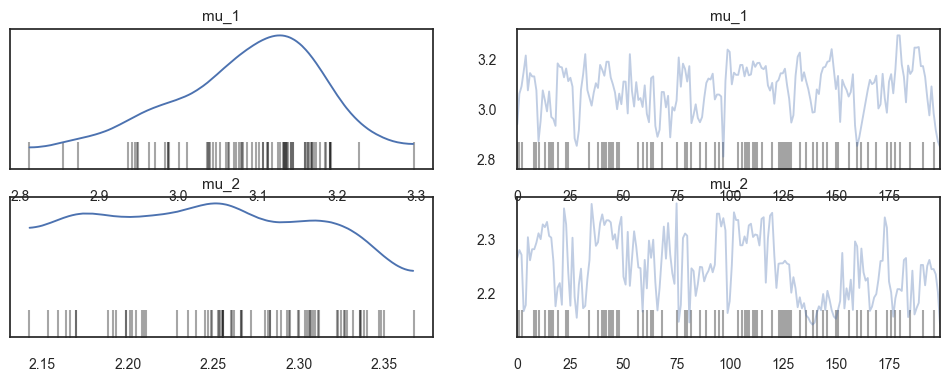

In [88]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(y_obs_label)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [89]:
posterior_samples

{'mu_1': tensor([2.9411, 3.0630, 3.0923, 3.1511, 3.2158, 3.0767, 3.1456, 3.1324, 3.1324,
         3.0765, 2.8734, 2.9551, 3.0765, 3.0374, 2.9926, 3.0721, 2.9704, 2.9623,
         2.9348, 3.1843, 3.1708, 3.1685, 3.1288, 3.1640, 3.1134, 3.1269, 3.0915,
         2.8851, 2.8549, 2.9172, 3.0792, 3.1403, 3.2213, 3.0780, 3.0473, 3.0156,
         3.0675, 3.1052, 3.0863, 3.1782, 3.1589, 3.1351, 3.1910, 3.1910, 3.1280,
         3.1009, 3.0684, 3.0013, 3.0636, 3.0213, 3.1119, 3.1114, 2.9845, 3.2213,
         3.0736, 3.0119, 3.1093, 3.0382, 3.0458, 3.0102, 3.0965, 2.9830, 2.9493,
         3.1252, 3.1325, 2.9344, 2.8911, 2.9194, 3.0701, 3.0699, 3.0088, 3.0549,
         2.8890, 3.0096, 2.9959, 3.0361, 3.2080, 3.0913, 3.1833, 3.1616, 3.1118,
         3.1733, 2.9456, 2.9788, 3.0209, 2.9666, 2.9493, 2.9699, 3.0459, 3.1065,
         3.1238, 3.1200, 3.1432, 3.0403, 3.0599, 3.0599, 3.0522, 2.8119, 3.1133,
         3.2395, 3.2303, 3.1006, 3.1472, 3.1386, 3.1386, 3.1781, 3.1781, 3.1326,
         3.1682, 3.1

In [90]:
mu_1_mean = posterior_samples["mu_1"].mean()
mu_2_mean = posterior_samples["mu_2"].mean()


In [91]:
loc_mean_posterior, loc_cov_posterior =[], []
for key, values in posterior_samples.items():
    print(key)
    if key == "sample_data":
        mean = values.mean(dim=0)
        cov = values.std(dim=0)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov.detach().numpy())
    elif key == "sigma_data":
        print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
    else:
        print("mean\n",values.mean(), "\nstd\n", values.std())

mu_1
mean
 tensor(3.0836, dtype=torch.float64) 
std
 tensor(0.0941, dtype=torch.float64)
mu_2
mean
 tensor(2.2483, dtype=torch.float64) 
std
 tensor(0.0604, dtype=torch.float64)


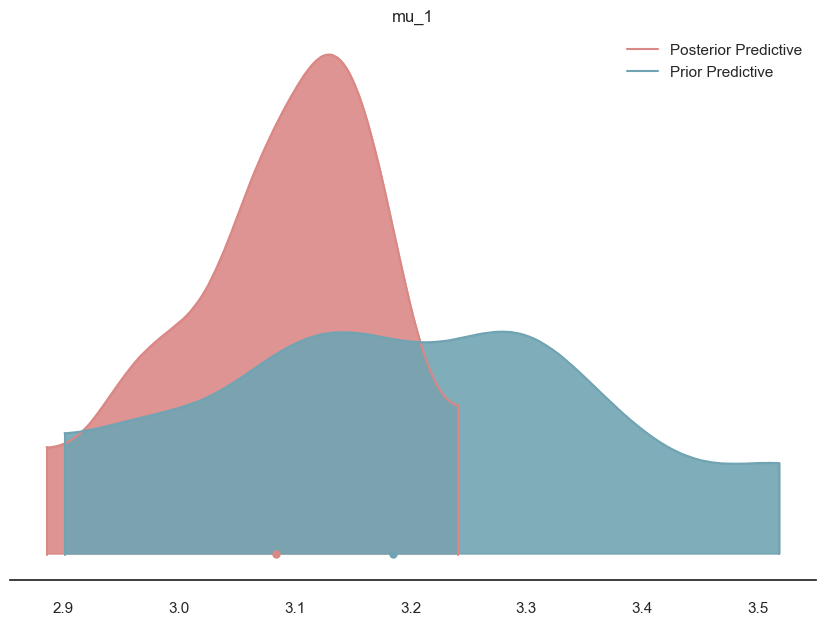

In [92]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

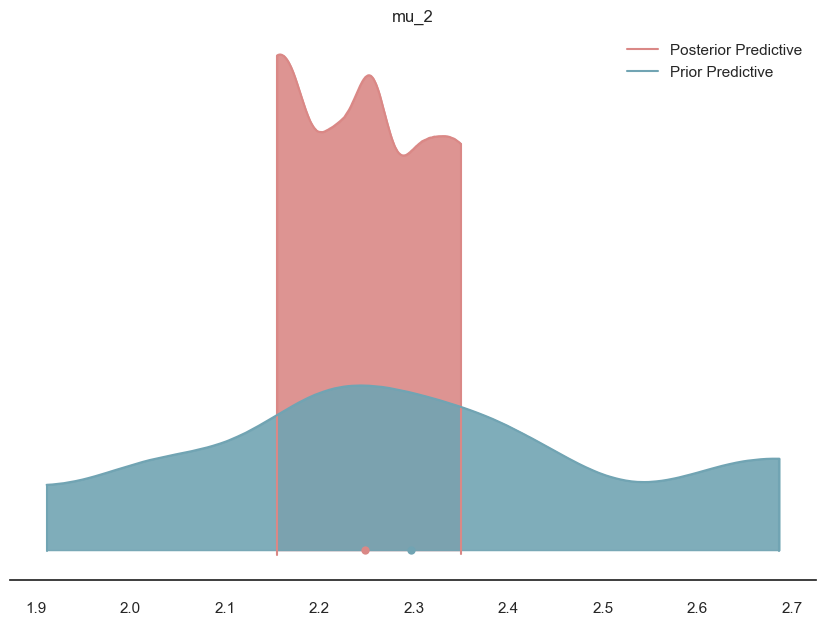

In [93]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

Condition number: 1545.6526085433686.


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


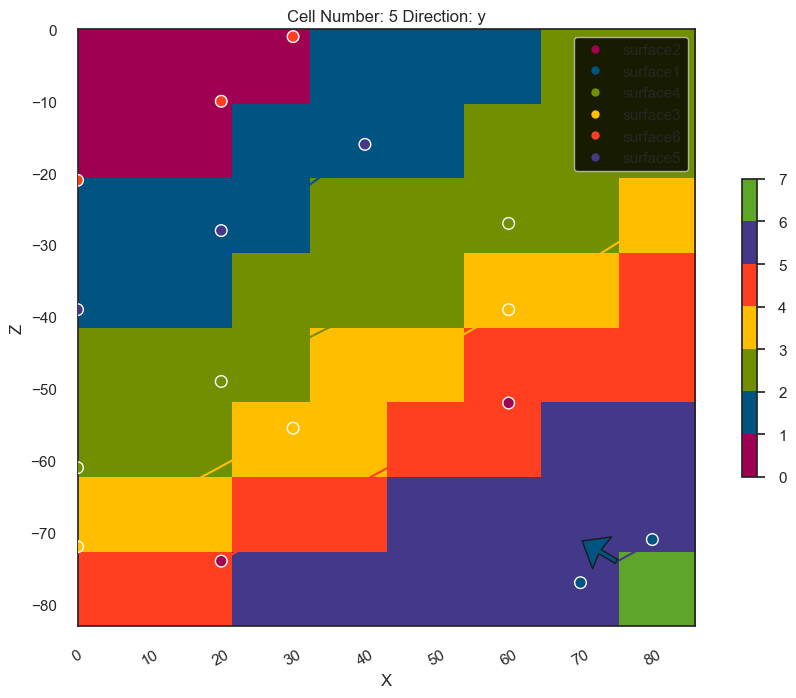

In [94]:
# Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([11]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([14]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [95]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

tensor([[-2.7500,  0.0000,  0.0000],
        [-0.7500,  0.0000,  1.1000],
        [-0.2500,  0.0000, -0.1500],
        [ 0.2500,  0.0000,  0.1500],
        [-3.7500,  0.0000,  0.6500],
        [-2.7500,  0.0000,  1.2500],
        [-0.7500,  0.0000,  2.3500],
        [-3.7500,  0.0000,  0.1000],
        [-2.2500,  0.0000,  0.9250],
        [-0.7500,  0.0000,  1.7500],
        [-3.7500,  0.0000,  2.6500],
        [-2.7500,  0.0000,  3.0836],
        [-2.2500,  0.0000,  3.6500],
        [-3.7500,  0.0000,  1.7500],
        [-2.7500,  0.0000,  2.2483],
        [-1.7500,  0.0000,  2.9000]], dtype=torch.float64,
       grad_fn=<IndexPutBackward0>)

In [96]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

array([[ 20.        ,   0.        , -74.        ],
       [ 60.        ,   0.        , -52.        ],
       [ 70.        ,   0.        , -77.        ],
       [ 80.        ,   0.        , -71.        ],
       [  0.        ,   0.        , -61.        ],
       [ 20.        ,   0.        , -49.        ],
       [ 60.        ,   0.        , -27.        ],
       [  0.        ,   0.        , -72.        ],
       [ 30.        ,   0.        , -55.5       ],
       [ 60.        ,   0.        , -39.        ],
       [  0.        ,   0.        , -21.        ],
       [ 20.        ,   0.        , -12.32737458],
       [ 30.        ,   0.        ,  -1.        ],
       [  0.        ,   0.        , -39.        ],
       [ 20.        ,   0.        , -29.03413385],
       [ 40.        ,   0.        , -16.        ]])

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


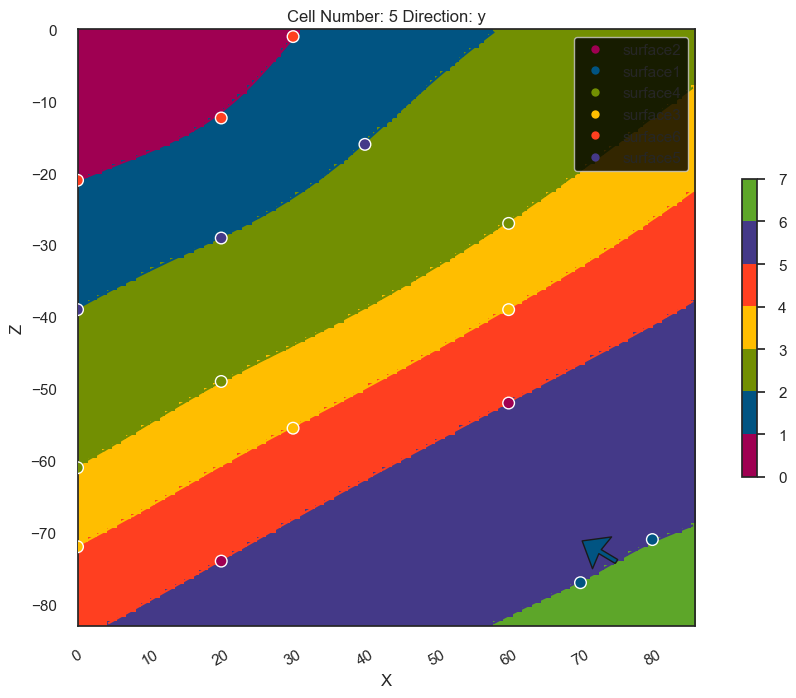

In [97]:
geo_model_test_post = gp.create_geomodel(
    project_name='Gempy_abc_Test_post',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=7,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

gp.add_surface_points(
    geo_model=geo_model_test_post,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test_post,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test_post.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([20.0, 60.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([-74, -52]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 30.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-72, -55.5, -39]),
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-61, -49, -27]),
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20, 40]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-39, sp_cord[14,2], -16]),
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0,30]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-21, sp_cord[11,2], -1]),
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element6)

geo_model_test_post.structural_frame.structural_groups[0].elements[0], geo_model_test_post.structural_frame.structural_groups[0].elements[1],\
geo_model_test_post.structural_frame.structural_groups[0].elements[2], geo_model_test_post.structural_frame.structural_groups[0].elements[3],\
geo_model_test_post.structural_frame.structural_groups[0].elements[4], geo_model_test_post.structural_frame.structural_groups[0].elements[5] = \
geo_model_test_post.structural_frame.structural_groups[0].elements[1], geo_model_test_post.structural_frame.structural_groups[0].elements[0],\
geo_model_test_post.structural_frame.structural_groups[0].elements[3], geo_model_test_post.structural_frame.structural_groups[0].elements[2],\
geo_model_test_post.structural_frame.structural_groups[0].elements[5], geo_model_test_post.structural_frame.structural_groups[0].elements[4]  

gp.compute_model(geo_model_test_post)
gpv.plot_2d(geo_model_test_post, cell_number=5, legend='force')
